<a href="https://colab.research.google.com/github/cbev/bross/blob/master/Sediment_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for developing regression equations for predicting suspended sediment concentrations (SSC) from remote sensing reflectance in major Bangladesh rivers**

Written by Claire Beveridge, University of Washington

In [0]:
#%% Data paths
data_dir='/content/drive/My Drive/Colab Notebooks/'
in_situ_dir=data_dir+'regression_files/'
in_situ_sediment_dir=in_situ_dir+'bwdb_sediment_103119/'
in_situ_streamflow_dir=in_situ_dir+'bwdb_streamflow_110319/'
gee_dir=data_dir+'gee_calibration_data/'

In [0]:
#%% Load relevant modules
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')
from scipy.optimize import curve_fit
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def ticks(y, pos):
    return r'$e^{:.0f}$'.format(np.log(y))
import sklearn.model_selection
import sklearn.metrics

In [0]:
#%% Functions

# Import sediment observations
def import_sed_obs(file):
    STA=pd.read_excel(file)
    STA.index=STA['Date'];
    STA.drop(['Date', 'RIVER_NAME', 'Station_ID', 'Name', 'Q', 'PPM'], axis=1, inplace=True);
    STA.rename(columns={"Sandkg/s": "coarse_sand_kgs",
                        "Finekg/s": "bulk_fine_kgs",
                        "MaxSandConcPPM":"bulk_fine_PPM_weight",
                        "SedCombKg/Sec":"combined_total_kgs",
                        "Q":"discharge_m3s"}, inplace=True)
    STA['discharge_calc_m3s']=STA['bulk_fine_kgs']/STA['bulk_fine_PPM_weight']*1000
    return STA

# Import streamflow data 
def import_q_obs(file):
    STA=pd.read_excel(file)
    STA.index=STA['Date'];
    STA.drop(['Date', 'RIVER_NAME', 'Station_ID', 'Name'], axis=1, inplace=True);
    STA.rename(columns={"Water_Level(m)": "water_level_m",
                        "Discharge(m)3/s": "discharge_m3s",
                        "Max_Velocity(m/s)":"max_velocity_ms"}, inplace=True)
    return STA

# Compute SSC
def compute_ssc(STA):
    # if there is an actual discharge measurement
    temp_mask=~pd.isna(STA['combined_total_kgs']) & ~pd.isna(STA['discharge_m3s'])
    temp_meas=pd.DataFrame(data=STA['combined_total_kgs'][temp_mask].values/STA['discharge_m3s'][temp_mask].values*1000,
                           index=STA.index[temp_mask], columns=['sed_mgl_meas_dis'])
    STA=STA.join(temp_meas, sort=True)
    
    temp_mask=STA['sed_mgl_meas_dis'].isin([np.nan, np.inf, -np.inf, 0])
    STA.loc[temp_mask, 'sed_mgl_meas_dis']=np.nan
    
    ## if there is a calcualted discharge measurement
    temp_mask=STA['discharge_calc_m3s'].isin([np.nan, np.inf, -np.inf, 0])
    STA.loc[temp_mask, 'discharge_calc_m3s']=np.nan

    temp_mask=~pd.isna(STA['combined_total_kgs']) & ~pd.isna(STA['discharge_calc_m3s'])
    temp_calc=pd.DataFrame(data=STA['combined_total_kgs'][temp_mask].values/STA['discharge_calc_m3s'][temp_mask].values*1000,
                           index=STA.index[temp_mask], columns=['sed_mgl_calc_dis'])
    STA=STA.join(temp_calc, sort=True)

    temp_mask=STA['sed_mgl_calc_dis'].isin([np.nan, np.inf, -np.inf, 0])
    STA.loc[temp_mask, 'sed_mgl_calc_dis']=np.nan
    STA.sort_index(inplace=True)
    return(STA)
 
# Import RS data-- need to do this for different sensors separately since you are taking the mean of images on the same day
def import_rs(STA):
    STA_rs=pd.read_csv(STA+'.csv',  index_col=0);
    if 'flag' in STA_rs.columns: STA_rs=STA_rs[STA_rs.flag!='bad']
    STA_rs = STA_rs.dropna(how='all')
    STA_rs.index=pd.to_datetime(STA_rs.index)    
    STA_rs = STA_rs.groupby(STA_rs.index).mean()
    STA_rs['total']=STA_rs.red+STA_rs.blue+STA_rs.green; STA_rs['station']=str(STA)
    STA_rs['red_nir']=STA_rs.red/STA_rs.nir;
    STA_rs['red_green']=STA_rs.red/STA_rs.green;
    STA_rs['red_blue']=STA_rs.red/STA_rs.blue;
    STA_rs['month']=STA_rs.index.month
    STA_rs=STA_rs.sort_index()
    return STA_rs   

# Plot monthly RS data
def plot_monthly(rs_list, title):
    fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) =plt.subplots(nrows=4,ncols=2, figsize=(12,8))
    rs_per_month=pd.DataFrame(index=np.arange(1,13),data=[len(rs_list[rs_list.month==1]), len(rs_list[rs_list.month==2]), len(rs_list[rs_list.month==3]), len(rs_list[rs_list.month==4]), 
     len(rs_list[rs_list.month==5]), len(rs_list[rs_list.month==6]), len(rs_list[rs_list.month==7]), len(rs_list[rs_list.month==8]),
     len(rs_list[rs_list.month==9]), len(rs_list[rs_list.month==10]), len(rs_list[rs_list.month==11]), len(rs_list[rs_list.month==12])])
    
    fig1.suptitle(title)
    ax1.plot(rs_list.month, rs_list.red, 'ro', markersize=3, fillstyle='none') #, label='SKB')
    ax1.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().red, 'ks-', markersize=3, fillstyle='none')
    ax1.set_xlabel('Month'); ax1.set_ylabel('red'); ax1.set_title('red')
    
    ax2.plot(rs_per_month.index, rs_per_month.values, 'ko-', markersize=3, fillstyle='none') #, label='SKB')  
    ax2.set_xlabel('Month'); ax2.set_ylabel('No of RS samples'); ax2.set_title('No. of RS samples per month')
    
    ax3.plot(rs_list.month, rs_list.green, 'go', markersize=3, fillstyle='none') #, label='SKB')
    ax3.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
    ax3.set_xlabel('Month'); ax3.set_ylabel('green'); ax3.set_title('green')
    
    ax4.plot(rs_list.month, rs_list.red/rs_list.green, 'go', markersize=3, fillstyle='none') #, label='SKB')
    ax4.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().red/rs_list.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
    ax4.set_xlabel('Month'); ax4.set_ylabel('red/green'); ax4.set_title('red/green')
    
    ax5.plot(rs_list.month, rs_list.blue, 'bo', markersize=3, fillstyle='none') #, label='SKB')
    ax5.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
    ax5.set_xlabel('Month'); ax5.set_ylabel('blue'); ax5.set_title('blue')
    
    ax6.plot(rs_list.month, rs_list.red/rs_list.blue, 'bo', markersize=3, fillstyle='none') #, label='SKB')
    ax6.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().red/rs_list.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
    ax6.set_xlabel('Month'); ax6.set_ylabel('red/blue'); ax6.set_title('red/blue')
    
    ax7.plot(rs_list.month, rs_list.nir, 'yo', markersize=3, fillstyle='none') #, label='SKB')
    ax7.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
    ax7.set_xlabel('Month'); ax7.set_ylabel('nir'); ax7.set_title('nir')
    
    ax8.plot(rs_list.month, rs_list.red/rs_list.nir, 'yo', markersize=3, fillstyle='none') #, label='SKB')
    ax8.plot(rs_list.groupby('month').median().index, rs_list.groupby('month').median().red/rs_list.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
    ax8.set_xlabel('Month'); ax8.set_ylabel('red/nir'); ax8.set_title('red/nir');
    
    print('Jan:', len(rs_list[rs_list.month==1])); print('Feb:', len(rs_list[rs_list.month==2]))
    print('Mar:', len(rs_list[rs_list.month==3])); print('Apr:', len(rs_list[rs_list.month==4]))
    print('May:', len(rs_list[rs_list.month==5])); print('Jun:', len(rs_list[rs_list.month==6]))
    print('Jul:', len(rs_list[rs_list.month==7])); print('Aug:', len(rs_list[rs_list.month==8]))
    print('Sep:', len(rs_list[rs_list.month==9])); print('Oct:', len(rs_list[rs_list.month==10]))
    print('Nov:', len(rs_list[rs_list.month==11])); print('Dec:', len(rs_list[rs_list.month==12]))
    print('Total:', len(rs_list))
  

# Find overlapping obs and RS data
def find_overlap(obs,rs,day_diff,pref):
    comp=pd.DataFrame(columns=['obs_date','obs_mgL','rs_date','blue','green','red','nir', 'source'])    
    j=0
    rs=rs.reset_index()
    rs=rs.rename(columns={"index":"date"})
#    rs_modis=rs[rs.LID ==3]
#    rs=rs[rs.LID !=3]
    for i in rs.index:
        start=rs.loc[i, 'date']-datetime.timedelta(day_diff+1);
        end=rs.loc[i, 'date']+datetime.timedelta(day_diff+1)
        mask=(obs.index > start) & (obs.index < end) # mask the rs data that overlaps the in=situ data within desired time range 
        dates=obs.index[mask]
        if dates.size==1: #if there's an rs obs that day
            comp.loc[j,'obs_date']=obs.index[mask][0]
            comp.loc[j,'obs_mgL_meas_dis']=obs.sed_mgl_meas_dis[mask][0]
            comp.loc[j,'obs_mgL_calc_dis']=obs.sed_mgl_calc_dis[mask][0]
            comp.loc[j,'obs_discharge_m3s']=obs.discharge_m3s[mask][0]
            comp.loc[j,'obs_discharge_calc_m3s']=obs.discharge_calc_m3s[mask][0]
            comp.loc[j,'coarse_sand_kgs']=obs.coarse_sand_kgs[mask][0]
            comp.loc[j,'bulk_fine_kgs']=obs.bulk_fine_kgs[mask][0]
            comp.loc[j,'rs_date']=rs.date[i]
            comp.loc[j,'blue']=rs.blue[i]
            comp.loc[j,'green']=rs.green[i]
            comp.loc[j,'red']=rs.red[i]
            comp.loc[j,'nir']=rs.nir[i]
            comp.loc[j,'station']=rs.station[i]
            comp.loc[j,'total']=rs.total[i]
            comp.loc[j,'LID']=rs.LID[i]
            comp.loc[j,'day_diff']=abs(rs.date[i]-obs.index[mask][0])
            j=j+1
        if dates.size>1: #if there's an rs obs that day
            dates_diff=abs(dates-rs.loc[i, 'date']) # find different between obs dates and rs dates
            mask_ind=np.where(dates_diff==np.amin(dates_diff)) # find where the minimum one is in the array
            if dates[mask_ind].size==1:
                comp.loc[j,'obs_date']=obs.index[mask][mask_ind[0]]
                comp.loc[j,'obs_mgL_meas_dis']=obs.sed_mgl_meas_dis[mask].values[mask_ind[0]]
                comp.loc[j,'obs_mgL_calc_dis']=obs.sed_mgl_calc_dis[mask].values[mask_ind[0]]
                comp.loc[j,'obs_discharge_m3s']=obs.discharge_m3s[mask].values[mask_ind[0]]
                comp.loc[j,'obs_discharge_calc_m3s']=obs.discharge_calc_m3s[mask].values[mask_ind[0]]
                comp.loc[j,'coarse_sand_kgs']=obs.coarse_sand_kgs[mask][0]
                comp.loc[j,'bulk_fine_kgs']=obs.bulk_fine_kgs[mask][0]                
                comp.loc[j,'rs_date']=rs.date[i]
                comp.loc[j,'blue']=rs.blue[i]
                comp.loc[j,'green']=rs.green[i]
                comp.loc[j,'red']=rs.red[i]
                comp.loc[j,'nir']=rs.nir[i]
                comp.loc[j,'station']=rs.station[i]
                comp.loc[j,'total']=rs.total[i]
                comp.loc[j,'LID']=rs.LID[i]
                comp.loc[j,'day_diff']=abs(rs.date[i]-obs.index[mask][mask_ind[0]])
                j=j+1
            else:
                comp.loc[j,'obs_date']=obs.index[mask].values[mask_ind[0][0]]
                comp.loc[j,'obs_mgL_meas_dis']=obs.sed_mgl_meas_dis[mask].values[mask_ind].mean()
                comp.loc[j,'obs_mgL_calc_dis']=obs.sed_mgl_calc_dis[mask].values[mask_ind].mean()
                comp.loc[j,'obs_discharge_m3s']=obs.discharge_m3s[mask].values[mask_ind].mean()
                comp.loc[j,'obs_discharge_calc_m3s']=obs.discharge_calc_m3s[mask].values[mask_ind].mean()
                comp.loc[j,'coarse_sand_kgs']=obs.coarse_sand_kgs[mask][0]
                comp.loc[j,'bulk_fine_kgs']=obs.bulk_fine_kgs[mask][0]   
                comp.loc[j,'rs_date']=rs.date[i]
                comp.loc[j,'blue']=rs.blue[i]
                comp.loc[j,'green']=rs.green[i]
                comp.loc[j,'red']=rs.red[i]
                comp.loc[j,'nir']=rs.nir[i]
                comp.loc[j,'station']=rs.station[i]
                comp.loc[j,'total']=rs.total[i]
                comp.loc[j,'LID']=rs.LID[i]
                comp.loc[j,'day_diff']=abs(rs.date[i]-obs.index[mask].values[mask_ind[0][0]])
                j=j+1
        
#    dups=comp[comp.duplicated(subset=['obs_date','LID'], keep=False)]
#    dups['day_diff']=abs(dups['obs_date']-dups['rs_date'])
#    dates=dups.obs_date.unique()
#    dups_update=pd.DataFrame(index=dates, columns=dups.columns)
#    
#    for i in dates:
#        mask=dups.obs_date==i
#        dups_update.loc[i, :]=dups.loc[dups[mask].day_diff.idxmin(),:]
#    
#    comp=comp[~comp.duplicated(subset=['obs_date','LID'], keep=False)]
#    comp=pd.concat([comp, dups_update], sort=True)
#    
#    # drop the duplicates and replace in the comparision data drame
#    comp.index=range(0,len(comp))

    if pref=='meas':
        if len(comp)>0: comp['obs_mgL']=comp['obs_mgL_meas_dis']
#        temp_mask=comp['obs_mgL'].isin([np.nan, np.inf, -np.inf, 0])
#        comp['obs_mgL'][temp_mask]=comp['obs_mgL_calc_dis']
        
    if pref=='calc':
        if len(comp)>0: comp['obs_mgL']=comp['obs_mgL_calc_dis']
#        temp_mask=comp['obs_mgL'].isin([np.nan, np.inf, -np.inf, 0])
#        comp['obs_mgL'][temp_mask]=comp['obs_mgL_meas_dis']
        
    comp=comp[~comp['obs_mgL'].isin([np.nan, np.inf, -np.inf, 0])]        
    comp.sort_index(inplace=True)
    return comp

# Plot overlapping RS and in situ data
def plot_rs_ts(STA_rs, title, L5L7):
    if L5L7=='yes':
        mask=np.concatenate([STA_rs[STA_rs.LID==5].index, STA_rs[STA_rs.LID==7].index])
        STA_rs.loc[mask, 'red']=0.0061 + 0.9047*STA_rs.loc[mask, 'red']
        STA_rs.loc[mask, 'blue']=0.0003 + 0.8474*STA_rs.loc[mask, 'blue']
        STA_rs.loc[mask, 'green']=0.0088 + 0.8483*STA_rs.loc[mask, 'green']
        STA_rs.loc[mask, 'nir']=0.0412 + 0.8462*STA_rs.loc[mask, 'nir']
    
    STA_rs['month']=STA_rs.index.month
    fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) =plt.subplots(nrows=4,ncols=2, figsize=(12,8))
    rs_per_month=pd.DataFrame(index=np.arange(1,13),data=[len(STA_rs[STA_rs.month==1]), len(STA_rs[STA_rs.month==2]), len(STA_rs[STA_rs.month==3]), len(STA_rs[STA_rs.month==4]), 
     len(STA_rs[STA_rs.month==5]), len(STA_rs[STA_rs.month==6]), len(STA_rs[STA_rs.month==7]), len(STA_rs[STA_rs.month==8]),
     len(STA_rs[STA_rs.month==9]), len(STA_rs[STA_rs.month==10]), len(STA_rs[STA_rs.month==11]), len(STA_rs[STA_rs.month==12])])
    
    fig1.suptitle(title)
    ax1.plot(STA_rs.index, STA_rs.red, 'ro-', markersize=3, fillstyle='none') #, label='SKB')
    #ax1.plot(STA_rs.groupby(pd.Grouper(freq='M')).mean(), STA_rs.groupby('month').median().red, 'ks-', markersize=3, fillstyle='none')
    ax1.set_xlabel('Month'); ax1.set_ylabel('red'); ax1.set_title('red')
    
    ax2.plot(rs_per_month.index, rs_per_month.values, 'ko-', markersize=3, fillstyle='none') #, label='SKB')  
    ax2.set_xlabel('Month'); ax2.set_ylabel('No of RS samples'); ax2.set_title('No. of RS samples per month')
    
    ax3.plot(STA_rs.index, STA_rs.green, 'go-', markersize=3, fillstyle='none') #, label='SKB')
    #ax3.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
    ax3.set_xlabel('Month'); ax3.set_ylabel('green'); ax3.set_title('green')
    
    ax4.plot(STA_rs.index, STA_rs.red/STA_rs.green, 'go-', markersize=3, fillstyle='none') #, label='SKB')
    #ax4.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().red/STA_rs.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
    ax4.set_xlabel('Month'); ax4.set_ylabel('red/green'); ax4.set_title('red/green')
    
    ax5.plot(STA_rs.index, STA_rs.blue, 'bo-', markersize=3, fillstyle='none') #, label='SKB')
    #ax5.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
    ax5.set_xlabel('Month'); ax5.set_ylabel('blue'); ax5.set_title('blue')
    
    ax6.plot(STA_rs.index, STA_rs.red/STA_rs.blue, 'bo-', markersize=3, fillstyle='none') #, label='SKB')
    #ax6.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().red/STA_rs.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
    ax6.set_xlabel('Month'); ax6.set_ylabel('red/blue'); ax6.set_title('red/blue')
    
    ax7.plot(STA_rs.index, STA_rs.nir, 'yo-', markersize=3, fillstyle='none') #, label='SKB')
    #ax7.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
    ax7.set_xlabel('Month'); ax7.set_ylabel('nir'); ax7.set_title('nir')
    
    ax8.plot(STA_rs.index, STA_rs.red/STA_rs.nir, 'yo-', markersize=3, fillstyle='none') #, label='SKB')
    #ax8.plot(STA_rs.groupby('month').median().index, STA_rs.groupby('month').median().red/STA_rs.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
    ax8.set_xlabel('Month'); ax8.set_ylabel('red/nir'); ax8.set_title('red/nir');
    
# Plot overlapping RS and in situ data
def plot_overlap(STA, STA_rs, STA_comp, title):
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(10, 6), sharex=True)
    ax1.plot(STA_comp['obs_date'], STA_comp['obs_mgL'], 'ko-', markersize=3, fillstyle='none', label='Obs')
    ax1.set_xlabel('Date'); ax1.set_ylabel('TSS (mg/L)'); ax1.set_title(title); ax1.legend(loc='best')
    
    ax2.plot(STA_comp['rs_date'], STA_comp['blue'], 'bo-', markersize=3, fillstyle='none', label='blue')
    ax2.plot(STA_comp['rs_date'], STA_comp['green'], 'go-', markersize=3, fillstyle='none', label='green')
    ax2.plot(STA_comp['rs_date'], STA_comp['red'], 'ro-', markersize=3, fillstyle='none', label='red')
    ax2.plot(STA_comp['rs_date'], STA_comp['nir'], 'yo-', markersize=3, fillstyle='none', label='nir')
    ax2.set_ylabel('Reflectance'); ax2.legend(loc='best')
    
    ax3.plot(STA_comp['rs_date'], STA_comp['red']/STA_comp['green'],'go-', fillstyle='none',markersize=4, linewidth=1, label='red/green')
    ax3.plot(STA_comp['rs_date'], STA_comp['red']/STA_comp['blue'],'bo-', fillstyle='none',markersize=4, linewidth=1, label='red/blue')
    ax3.plot(STA_comp['rs_date'], STA_comp['red']/STA_comp['nir'],'yo-', fillstyle='none',markersize=4, linewidth=1, label='red/NIR')
    ax3.set_xlabel('Date'); ax3.set_ylabel('Reflectance ratio'); ax3.tick_params(rotation=35); ax3.legend(loc='best')
    #ax3.set_ylim([0.5,2.5]);
    
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(16,6), sharex=True, sharey=False)
    ax1.plot(STA_comp['obs_date'], STA_comp['obs_mgL'], 'ko-', markersize=3, fillstyle='none', linewidth=1,label='Obs')
    ax1.set_xlabel('Date'); ax1.set_ylabel('TSS (mg/L)'); ax1.tick_params(rotation=35);  ax1.set_title(title); ax1.legend(loc='best')
    
    ax2.plot(STA_rs.index, STA_rs['red'],'ro-', fillstyle='none',markersize=4, linewidth=1, label='red')
    ax2.plot(STA_rs.index, STA_rs['green'],'go-', fillstyle='none',markersize=4, linewidth=1, label='green')
    ax2.plot(STA_rs.index, STA_rs['blue'],'bo-', fillstyle='none',markersize=4, linewidth=1, label='blue')
    ax2.plot(STA_rs.index, STA_rs['nir'],'yo-', fillstyle='none',markersize=4, linewidth=1, label='NIR')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Reflectance'); ax2.tick_params(rotation=35); ax2.legend(loc='best')
    
    ax3.plot(STA_rs.index, STA_rs['red']/STA_rs['green'],'go-', fillstyle='none',markersize=4, linewidth=1, label='red/green')
    ax3.plot(STA_rs.index, STA_rs['red']/STA_rs['blue'],'bo-', fillstyle='none',markersize=4, linewidth=1, label='red/blue')
    ax3.plot(STA_rs.index, STA_rs['red']/STA_rs['nir'],'yo-', fillstyle='none',markersize=4, linewidth=1, label='red/NIR')
    ax3.set_xlabel('Date'); ax3.set_ylabel('Reflectance ratio'); ax3.tick_params(rotation=35); ax3.legend(loc='best')
    #ax3.set_ylim([0,4.5]);

def plot_distribution(STA, STA_comp, title):
    fig1, ax1 =plt.subplots(1,1,figsize=(10, 6), sharex=True)
    ax1.plot(STA['discharge_m3s'], STA['combined_total_kgs'], 'ko', markersize=3, label='Observation')
    ax1.plot(STA_comp['obs_discharge_m3s'], STA_comp['coarse_sand_kgs']+STA_comp['bulk_fine_kgs'], 'ro', markersize=5, label='Calibration Point')
    ax1.set_xlabel('Streamflow'); ax1.set_ylabel('TSS (mg/L)'); ax1.set_title(title); ax1.legend(loc='best')
    ax1.set_xscale('log'); ax1.set_yscale('log')

# Empirical calibration
def expn(x, a, b, c):
    return a*np.exp(b*x+c)

def linear(x, a, b):
    return a*x+b

def poly_2ord(x, a, b, c):
    return a*x**2+b*x+c

def fit(band,obs,p0, function):
    popt, pcov = curve_fit(function, band, obs, p0)
    # https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    residuals = obs- function(band, *popt)
    ss_res = np.sum(residuals**2)
    r_squared=sklearn.metrics.r2_score(obs,function(band, *popt))
    #ss_tot = np.sum((obs-np.mean(obs))**2)
    #r_squared = 1 - (ss_res / ss_tot)
    rmse = np.sqrt((residuals ** 2).mean())

    return np.sort(band), function(np.sort(band), *popt), ss_res, r_squared, rmse, popt

In [0]:
#%% Upload and plot in-situ data
### OPTIONS
export_insitu='no' #'yes'
drop_incomplete_first='no'
#########

os.chdir(in_situ_sediment_dir)

# Import sediment data
BD_s=import_sed_obs('Sedim_SW46.9L-BD.xlsx');
BA_s=import_sed_obs('Sedim_SW91.9L-BA.xlsx'); 
MW_s=import_sed_obs('Sedim_SW93.5L-MW.xlsx');
HB_s=import_sed_obs('Sedim_SW90-HB.xlsx');

# add BWDB streamflow
os.chdir(in_situ_streamflow_dir)

BD_q=import_q_obs('Discharge_SW46.9L-BD.xlsx');
BA_q=import_q_obs('Discharge_SW91.9L-BA.xlsx');
MW_q=import_q_obs('Discharge_SW93.5L-MW.xlsx');
HB_q=import_q_obs('Discharge_SW90-HB.xlsx');

# merge sediment and streamflow data
BD=BD_s.merge(BD_q, how='outer', left_index=True, right_index=True)
BA=BA_s.merge(BA_q, how='outer', left_index=True, right_index=True)
MW=MW_s.merge(MW_q, how='outer', left_index=True, right_index=True)
HB=HB_s.merge(HB_q, how='outer', left_index=True, right_index=True)
BD['station']='BD'; BA['station']='BA'; MW['station']='MW'; HB['station']='HB'; 
BD['source']='BWDB'; BA['source']='BWDB'; MW['source']='BWDB'; HB['source']='BWDB'; 

BA.drop_duplicates(inplace=True); BD.drop_duplicates(inplace=True)
MW.drop_duplicates(inplace=True); HB.drop_duplicates(inplace=True)

# add on IWM data that is not in BWDB dataset
os.chdir(in_situ_dir)
BD_iwm=pd.read_excel('iwm_sediment_091219.xlsx', sheet_name='Bahadurbad', index_col=0)
BD_iwm.rename(columns={"Sed (kg/sec)": "combined_total_kgs",
                        "Discharge": "discharge_m3s"}, inplace=True)

HB_iwm=pd.read_excel('iwm_sediment_091219.xlsx', sheet_name='Hardinge', index_col=0)
HB_iwm.rename(columns={"Suspended Sediment,Kg/sec": "combined_total_kgs",
                        "Discharge, m3": "discharge_m3s"}, inplace=True)

BD_iwm['station']='BD'; HB_iwm['station']='HB'
BD_iwm['source']='IWM'; HB_iwm['source']='IWM'

BD_iwm=BD_iwm[np.isin(BD_iwm.index, (BD_s.index & BD_q.index) , invert=True)]
HB_iwm=HB_iwm[np.isin(HB_iwm.index, (HB_s.index & HB_q.index), invert=True)] # returns flag

BD.drop(index=BD_iwm.index[np.isin(BD_iwm.index, BD.index)], inplace=True)
HB.drop(index=HB_iwm.index[np.isin(HB_iwm.index, HB.index)], inplace=True)

BD=pd.concat([BD,BD_iwm], sort=True)
HB=pd.concat([HB,HB_iwm], sort=True)

del(BD_s); del(BA_s); del(MW_s); del(HB_s); del(BD_q); del(BA_q); del(MW_q); del(HB_q); del(BD_iwm); del(HB_iwm)

#### Corrections #####

if drop_incomplete_first=='yes':
    BD=BD[~BD['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BD=BD[~BD['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BA=BA[~BA['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BA=BA[~BA['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    MW=MW[~MW['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    MW=MW[~MW['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    HB=HB[~HB['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    HB=HB[~HB['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]    
else: 
    BA.drop(datetime.datetime(2009, 7, 23), inplace=True)
    BD.drop(BD.loc[datetime.datetime(1988, 8, 8):datetime.datetime(1988, 8, 22)].index, inplace=True)
#    BD.drop(datetime.datetime(2009, 8, 29), inplace=True)
#    BD.drop(BD.loc[datetime.datetime(1989, 8, 21):datetime.datetime(1990, 3, 19)].index, inplace=True)
#    BD.drop(BD.loc[datetime.datetime(1990, 5, 22):datetime.datetime(1990, 9, 10)].index, inplace=True)
#    BD.drop(BD.loc[datetime.datetime(1990, 9, 24):datetime.datetime(1990, 10, 10)].index, inplace=True)
#    BD.drop(BD.loc[datetime.datetime(1991, 10, 7):datetime.datetime(1993, 7, 6)].index, inplace=True)
    BA.drop(datetime.datetime(2009, 8, 20), inplace=True)
    BD.loc[datetime.datetime(1994, 3, 28), 'discharge_calc_m3s']=8240
    BD.drop(datetime.datetime(1994, 3, 28), inplace=True)
# Drop
BA.drop(BA.loc[datetime.datetime(1992, 2, 6):datetime.datetime(1992, 7, 23)].index, inplace=True)
BA.drop(BA.loc[datetime.datetime(1992, 11, 12):datetime.datetime(1993, 2, 18 )].index, inplace=True)
BA.drop(BA.loc[datetime.datetime(1993, 4, 1):datetime.datetime(1993, 5, 27)].index, inplace=True)
BA.drop(datetime.datetime(1994, 9, 2), inplace=True)
BA.drop(datetime.datetime(1996, 9, 5), inplace=True)
BA.drop(BA.loc[datetime.datetime(2005, 7, 14):datetime.datetime(2005, 12, 3)].index, inplace=True)
BA.drop(BA.loc[datetime.datetime(2012, 1, 1):datetime.datetime(2013, 1, 1)].index, inplace=True)
MW.drop(datetime.datetime(2016, 6, 8), inplace=True)


# Discharge- measured (m3/s)
BA.loc[datetime.datetime(2003, 8, 7), 'discharge_m3s']=80929.9
BA.loc[datetime.datetime(2004, 6, 3), 'discharge_m3s']=28243.3
BA.loc[datetime.datetime(2004, 6, 10), 'discharge_m3s']=27165.4
BA.loc[datetime.datetime(2004, 7, 15), 'discharge_m3s']=111769
BA.loc[datetime.datetime(2006, 9, 23), 'discharge_m3s']=61454.2
temp_mask=(HB.index >= datetime.datetime(2000, 6, 5)) & (HB.index <= datetime.datetime(2000, 8, 21))
HB.loc[HB[temp_mask].index, 'discharge_m3s']=HB[temp_mask]['discharge_m3s'].values*1000
temp_mask=(HB.index >= datetime.datetime(2000, 8, 28)) & (HB.index <= datetime.datetime(2000, 11, 27))
HB.loc[HB[temp_mask].index, 'discharge_m3s']=HB[temp_mask]['discharge_m3s'].values*1000
MW.loc[datetime.datetime(2012, 7, 11), 'discharge_m3s']=49990.6

# Discharge- calculated (m3/s)

BD.loc[datetime.datetime(2013, 7, 8), 'discharge_calc_m3s']=49290.9
BD.loc[datetime.datetime(2013, 9, 10), 'discharge_calc_m3s']=75660.1

# sediment discharge
BA.loc[datetime.datetime(2004, 10, 21), 'combined_total_kgs']=6280.33+4515.2


#########
# Compute SSC from streamflow
BD=compute_ssc(BD)
BA=compute_ssc(BA)
MW=compute_ssc(MW)
HB=compute_ssc(HB)

# Combine into a single array
obs_list=[BD, BA, MW, HB]
obs_all=pd.concat(obs_list, sort=True)

obs_all=obs_all[~obs_all['combined_total_kgs'].isin([0, np.nan, np.inf, -np.inf])]

# Export insitu data
if export_insitu=='yes':
    export_csv = obs_all.to_csv (data_dir+'export_dataframe.csv', header=True)
    
#BD.sed_mgl_meas_dis[BD.sed_mgl_meas_dis>0]
#plt.plot(BD.sed_mgl_meas_dis[BD.sed_mgl_meas_dis>0])
#
#BA.sed_mgl_meas_dis[BA.sed_mgl_meas_dis>0]
#plt.plot(BA.sed_mgl_meas_dis[BA.sed_mgl_meas_dis>0])
#
#HB.sed_mgl_meas_dis[HB.sed_mgl_meas_dis>0]
#plt.plot(HB.sed_mgl_meas_dis[HB.sed_mgl_meas_dis>0])
#
#MW.sed_mgl_meas_dis[MW.sed_mgl_meas_dis>0]
#plt.plot(MW.sed_mgl_meas_dis[MW.sed_mgl_meas_dis>0])

In [0]:
#%%
### OPTIONS ###
plot_insitu='no' #'yes'
plot_streamflow='no' # 'yes'
###############

##%% Compare different streamflow options
if plot_streamflow=='yes':
    plt.figure()
    plt.loglog(obs_all.discharge_m3s, obs_all.discharge_calc_m3s, 'bo')
    plt.xlabel('Observed'); plt.ylabel('Computed')
    plt.axis('equal')
    plt.title('Streamflow Discharge: Computed vs. Observed')

    plt.figure()
    plt.loglog(obs_all.sed_mgl_meas_dis, obs_all.sed_mgl_calc_dis, 'ko')
    plt.xlabel('Observed'); plt.ylabel('Computed')
    plt.axis('equal')
    plt.title('SSC: Computed vs. Observed')
    
    plt.figure()
    plt.loglog(obs_all.sed_mgl_meas_dis,obs_all.sed_mgl_meas_dis-obs_all.sed_mgl_calc_dis, 'ko')
    plt.xlabel('Observed'); plt.ylabel('Computed')
    plt.axis('equal')
    plt.title('SSC: Computed vs. Observed')

def make_plot_insitu_monthly_avg(STA, title, scale, show_calc):
    STA=STA.groupby(pd.Grouper(freq='M')).mean()
    months=STA.index.month
    STA=STA.groupby(months).mean()
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(12,10), sharex=True)
    ax1.plot(STA.index, STA.combined_total_kgs, 'ko-', markersize=3, fillstyle='none')
    ax1.set_ylabel('Qs (kg/s)'); 
    ax1.set_title('Monthly Averages'+'\n'+title+'\nSediment Discharge (kg/s)')

    if show_calc=='yes': ax2.plot(STA.index, STA.discharge_calc_m3s, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax2.plot(STA.index, STA.discharge_m3s, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax2.set_ylabel('Q (m3/s)')
    ax2.set_title('Streamflow Discharge (m3/s)')
    #ax2.legend(loc='best', ncol=2)
    
    if show_calc=='yes': ax3.plot(STA.index, STA.sed_mgl_calc_dis, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax3.plot(STA.index, STA.sed_mgl_meas_dis, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax3.set_xlabel('Date'); ax3.set_ylabel('SSC (mg/L)')
    ax3.set_title('Sediment Concentration (mg/L)')
    #ax3.legend(loc='upper left', ncol=2)
    
    if scale=='log': ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log');
    
    return STA
## plot in situ data
if plot_insitu=='yes':
    BD_avg=make_plot_insitu_monthly_avg(BD, 'Bahadurabad', 'linear', 'no')
    BA_avg=make_plot_insitu_monthly_avg(BA, 'Bauria', 'linear', 'no')
    MW_avg=make_plot_insitu_monthly_avg(MW, 'Mawa', 'linear', 'no')
    HB_avg=make_plot_insitu_monthly_avg(HB, 'Hardinge Bridge', 'linear', 'no')   

def make_plot_insitu_monthly(STA, STA_avg, title, scale, show_calc, show_month):
    STA= STA[STA.combined_total_kgs>0]
    STA=STA.groupby(pd.Grouper(freq='M')).mean()
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(12,10), sharex=True)
    if show_month=='yes':ax1.plot(STA.index, STA_avg.loc[STA.index.month,'combined_total_kgs'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    ax1.plot(STA.index, STA.combined_total_kgs, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax1.set_ylabel('Qs (kg/s)'); 
    ax1.set_title('Per Month Averages'+'\n'+title+'\nSediment Discharge (kg/s)')

    if show_month=='yes':ax2.plot(STA.index, STA_avg.loc[STA.index.month,'discharge_m3s'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    if show_calc=='yes': ax2.plot(STA.index, STA.discharge_calc_m3s, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax2.plot(STA.index, STA.discharge_m3s, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax2.set_ylabel('Q (m3/s)')
    ax2.set_title('Streamflow Discharge (m3/s)')
    #ax2.legend(loc='best', ncol=2)
    
    if show_month=='yes':ax3.plot(STA.index, STA_avg.loc[STA.index.month,'sed_mgl_meas_dis'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    if show_calc=='yes': ax3.plot(STA.index, STA.sed_mgl_calc_dis, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax3.plot(STA.index, STA.sed_mgl_meas_dis, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax3.set_xlabel('Date'); ax3.set_ylabel('SSC (mg/L)')
    ax3.set_title('Sediment Concentration (mg/L)')
    #ax3.legend(loc='upper left', ncol=2)
    
    if scale=='log': ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log');

## plot in situ data
if plot_insitu=='yes':
    make_plot_insitu_monthly(BD, BD_avg, 'Bahadurabad', 'linear', 'no', 'no')
    make_plot_insitu_monthly(BA, BA_avg, 'Bauria', 'linear', 'no', 'no')
    make_plot_insitu_monthly(MW, MW_avg, 'Mawa', 'linear', 'no', 'no')
    make_plot_insitu_monthly(HB, HB_avg, 'Hardinge Bridge', 'linear', 'no', 'no')  
    
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(8,4), sharex=True)
    ax1.plot(BD_avg.index, BD_avg['combined_total_kgs'], 'ko-', markersize=3, fillstyle='none', label='BD')
    ax1.plot(BA_avg.index, BA_avg['combined_total_kgs'], 'bo-', markersize=3, fillstyle='none', label='BA')
    ax1.plot(MW_avg.index, MW_avg['combined_total_kgs'], 'ro-', markersize=3, fillstyle='none', label='MW')
    ax1.plot(HB_avg.index, HB_avg['combined_total_kgs'], 'go-', markersize=3, fillstyle='none', label='HB')
    ax1.set_ylabel('Qs (kg/s)'); 
    ax1.set_title('Sediment Discharge (kg/s)')
    ax1.legend(loc='best', ncol=2)
    
    ax2.plot(BD_avg.index, BD_avg['discharge_m3s'], 'ko-', markersize=3, fillstyle='none', label='BD')
    ax2.plot(BA_avg.index, BA_avg['discharge_m3s'], 'bo-', markersize=3, fillstyle='none', label='BA')
    ax2.plot(MW_avg.index, MW_avg['discharge_m3s'], 'ro-', markersize=3, fillstyle='none', label='MW')
    ax2.plot(HB_avg.index, HB_avg['discharge_m3s'], 'go-', markersize=3, fillstyle='none', label='HB')
    ax2.set_ylabel('Q (m3/s)')
    ax2.set_title('Streamflow Discharge (m3/s)')
    ax2.legend(loc='best', ncol=2)
    
    ax3.plot(BD_avg.index, BD_avg['sed_mgl_meas_dis'], 'ko-', markersize=3, fillstyle='none', label='BD')
    ax3.plot(BA_avg.index, BA_avg['sed_mgl_meas_dis'], 'bo-', markersize=3, fillstyle='none', label='BA')
    ax3.plot(MW_avg.index, MW_avg['sed_mgl_meas_dis'], 'ro-', markersize=3, fillstyle='none', label='MW')
    ax3.plot(HB_avg.index, HB_avg['sed_mgl_meas_dis'], 'go-', markersize=3, fillstyle='none', label='HB')
    ax3.set_xlabel('Date'); ax3.set_ylabel('SSC (mg/L)')
    ax3.set_title('Sediment Concentration (mg/L)')
    ax3.legend(loc='upper left', ncol=2) 

def make_plot_insitu(STA, STA_avg, title, scale, show_calc, show_month):   
    STA= STA[STA.combined_total_kgs>0]
    fig1, (ax1, ax2, ax3) =plt.subplots(3,1,figsize=(12,10), sharex=True)
    if show_month=='yes':ax1.plot(STA.index, STA_avg.loc[STA.index.month,'combined_total_kgs'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    ax1.plot(STA.index, STA.combined_total_kgs, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax1.set_ylabel('Qs (kg/s)'); 
    #ax1.legend(loc='best', ncol=2)
    ax1.set_title('Daily'+'\n'+title+'\nSediment Discharge (kg/s)')

    if show_month=='yes':ax2.plot(STA.index, STA_avg.loc[STA.index.month,'discharge_m3s'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    if show_calc=='yes': ax2.plot(STA.index, STA.discharge_calc_m3s, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax2.plot(STA.index, STA.discharge_m3s, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax2.set_ylabel('Q (m3/s)')
    ax2.set_title('Streamflow Discharge (m3/s)')
    #ax2.legend(loc='best', ncol=2)
    
    if show_month=='yes':ax3.plot(STA.index, STA_avg.loc[STA.index.month,'sed_mgl_meas_dis'], 'ro-', markersize=3, fillstyle='none', label='monthly avg')
    if show_calc=='yes': ax3.plot(STA.index, STA.sed_mgl_calc_dis, 'bs-', markersize=3, fillstyle='none', label='computed')
    ax3.plot(STA.index, STA.sed_mgl_meas_dis, 'ko-', markersize=3, fillstyle='none', label='measured')
    ax3.set_xlabel('Date'); ax3.set_ylabel('SSC (mg/L)')
    ax3.set_title('Sediment Concentration (mg/L)')
    #ax3.legend(loc='upper left', ncol=2)
    
    if scale=='log': ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log');
## plot in situ data
if plot_insitu=='yes':
    make_plot_insitu(BD, BD_avg,'Bahadurabad', 'linear', 'no', 'no')
    make_plot_insitu(BA, BA_avg,'Bauria', 'linear', 'no', 'no')
    make_plot_insitu(MW, MW_avg,'Mawa', 'linear', 'no', 'no')
    make_plot_insitu(HB, HB_avg,'Hardinge Bridge', 'linear', 'no', 'no')  

In [0]:
#%% RS data- load and delete the band calibration data
### OPTIONS
band_thresh_r=0.3
band_thresh_b=0.3 
band_thresh_g=0.3 
band_thresh_n=0.3
band_thresh_rg=4
band_thresh_rb=3
band_thresh_rn=4 
plot_monthly_all='no' # 'yes'
plot_rs_dist='no' # 'yes'
make_plot_rs_ts='no' # 'yes'
#########

os.chdir(gee_dir+'Landsat_cloud_strict')
BD_rs=import_rs('BD'); BA_rs=import_rs('BA'); MW_rs=import_rs('MW'); HB_rs=import_rs('HB');

os.chdir(gee_dir+'/modis')
HB_rs_m=import_rs('HB'); HB_rs_m['LID']=3*np.ones(len(HB_rs_m)); HB_rs=pd.concat([HB_rs, HB_rs_m], sort=True)
MW_rs_m=import_rs('MW'); MW_rs_m['LID']=3*np.ones(len(MW_rs_m)); MW_rs=pd.concat([MW_rs, MW_rs_m], sort=True)
BA_rs_m=import_rs('BA'); BA_rs_m['LID']=3*np.ones(len(BA_rs_m)); BA_rs=pd.concat([BA_rs, BA_rs_m], sort=True)
BD_rs_m=import_rs('BD'); BD_rs_m['LID']=3*np.ones(len(BD_rs_m)); BD_rs=pd.concat([BD_rs, BD_rs_m], sort=True)

os.chdir(gee_dir+'/s2')
HB_rs_s2=import_rs('HB'); HB_rs_s2['LID']=2*np.ones(len(HB_rs_s2)); HB_rs=pd.concat([HB_rs, HB_rs_s2], sort=True)
MW_rs_s2=import_rs('MW'); MW_rs_s2['LID']=2*np.ones(len(MW_rs_s2)); MW_rs=pd.concat([MW_rs, MW_rs_s2], sort=True)
BA_rs_s2=import_rs('BA'); BA_rs_s2['LID']=2*np.ones(len(BA_rs_s2)); BA_rs=pd.concat([BA_rs, BA_rs_s2], sort=True)
BD_rs_s2=import_rs('BD'); BD_rs_s2['LID']=2*np.ones(len(BD_rs_s2)); BD_rs=pd.concat([BD_rs, BD_rs_s2], sort=True)

HB_rs=HB_rs.sort_index(); MW_rs=MW_rs.sort_index(); BA_rs=BA_rs.sort_index(); BD_rs=BD_rs.sort_index()
del(HB_rs_m); del(MW_rs_m); del(BA_rs_m); del(BD_rs_m);
del(HB_rs_s2); del(MW_rs_s2); del(BA_rs_s2); del(BD_rs_s2);

rs_list=[BD_rs, BA_rs, MW_rs, HB_rs]

for rs in rs_list:
    rs.dropna(axis=0, thresh=2, inplace=True)
    if rs.index[rs.red>band_thresh_r].empty==False: rs.drop(index=rs.index[rs.red>band_thresh_r], inplace=True)
    if rs.index[rs.blue>band_thresh_b].empty==False: rs.drop(index=rs.index[rs.blue>band_thresh_b], inplace=True)
    if rs.index[rs.green>band_thresh_g].empty==False: rs.drop(index=rs.index[rs.green>band_thresh_g], inplace=True)
    if rs.index[rs.nir>band_thresh_n].empty==False: rs.drop(index=rs.index[rs.nir>band_thresh_n], inplace=True)

rs_all=pd.concat([BD_rs, BA_rs, MW_rs, HB_rs], sort=True)

if plot_monthly_all=='yes':
    plot_monthly(BD_rs[BD_rs.LID.isin([5, 7])], 'BD-Landsat 5 & 7');
    plot_monthly(BA_rs[BA_rs.LID.isin([5, 7])], 'BA-Landsat 5 & 7');
    plot_monthly(HB_rs[HB_rs.LID.isin([5, 7])], 'HB-Landsat 5 & 7');
    plot_monthly(MW_rs[MW_rs.LID.isin([5, 7])], 'MW-Landsat 5 & 7');
    
    plot_monthly(BD_rs[BD_rs.LID.isin([2, 8])], 'BD-Landsat 8 & Sentinel-2');
    plot_monthly(BA_rs[BA_rs.LID.isin([2, 8])], 'BA-Landsat 8 & Sentinel-2');
    plot_monthly(HB_rs[HB_rs.LID.isin([2, 8])], 'HB-Landsat 8 & Sentinel-2');
    plot_monthly(MW_rs[MW_rs.LID.isin([2, 8])], 'MW-Landsat 8 & Sentinel-2');
    
    plot_monthly(BD_rs[BD_rs.LID==3], 'BD-MODIS');
    plot_monthly(BA_rs[BA_rs.LID==3], 'BA-MODIS');
    plot_monthly(HB_rs[HB_rs.LID==3], 'HB-MODIS');
    plot_monthly(MW_rs[MW_rs.LID==3], 'MW-MODIS');

if plot_rs_dist=='yes':
    fig1, (ax1) =plt.subplots(1,1,figsize=(8, 6), sharex=True, sharey=False)
    ax2 = ax1.twinx()
    ax1.plot(np.sort(rs_all.red),'r.', label='red')
    ax1.plot(np.sort(rs_all.blue),'b.', label='blue')
    ax1.plot(np.sort(rs_all.green),'g.', label='green')
    ax1.plot(np.sort(rs_all.nir),'y.', label='nir')
#    ax2.plot(np.sort(rs_all.red/rs_all.nir),'y.', label='red/nir')
#    ax2.plot(np.sort(rs_all.red/rs_all.green),'g.', label='red/green')
#    ax2.plot(np.sort(rs_all.red/rs_all.blue),'b.',  label='red/blue')
#    ax1.axhline(0.15, color='red', linestyle='-', label='red=0.15')
#    ax2.axhline(1.24, color='green', linestyle='-', label='red/green=1.24')
    ax1.set_xlabel('Plotting Position')
    ax1.set_ylabel('Red Band Value')
    ax2.set_ylabel('Band Ratio Value')
    ax1.set_title('Distribution of Remote Sensing Values')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center')
 
#    print('percent red>0.15=',100*len(rs_all.red[rs_all.red>=0.15])/len(rs_all.red))
#    print('percent red/green>1.41=',100*len((rs_all.red/rs_all.green)[(rs_all.red/rs_all.green)>=1.241])/len(rs_all.red/rs_all.green))
if make_plot_rs_ts=='yes' :
    plot_rs_ts(BD_rs[BD_rs.LID.isin([5, 7])], 'BD-Landsat 5 & 7', 'no')
    plot_rs_ts(BA_rs[BA_rs.LID.isin([5, 7])], 'BA-Landsat 5 & 7', 'no')
    plot_rs_ts(MW_rs[MW_rs.LID.isin([5, 7])], 'MW-Landsat 5 & 7', 'no')
    plot_rs_ts(HB_rs[HB_rs.LID.isin([5, 7])], 'HB-Landsat 5 & 7', 'no')

    plot_rs_ts(BD_rs[BD_rs.LID.isin([2, 8])], 'BD-Landsat 8 & Sentinel-2', 'no')
    plot_rs_ts(BA_rs[BA_rs.LID.isin([2, 8])], 'BA-Landsat 8 & Sentinel-2',  'no')
    plot_rs_ts(MW_rs[MW_rs.LID.isin([2, 8])], 'MW-Landsat 8 & Sentinel-2',  'no')
    plot_rs_ts(HB_rs[HB_rs.LID.isin([2, 8])], 'HB-Landsat 8 & Sentinel-2',  'no')

    plot_rs_ts(BD_rs[BD_rs.LID.isin([3])], 'BD-MODIS', 'no')
    plot_rs_ts(BA_rs[BA_rs.LID.isin([3])], 'BA-MODIS', 'no')
    plot_rs_ts(MW_rs[MW_rs.LID.isin([3])], 'MW-MODIS', 'no')
    plot_rs_ts(HB_rs[HB_rs.LID.isin([3])], 'HB-MODIS', 'no')


def rs_per_month(STA_rs):
    rs_per_month=pd.DataFrame(index=np.arange(1,13),data=[len(STA_rs[STA_rs.month==1]), len(STA_rs[STA_rs.month==2]), len(STA_rs[STA_rs.month==3]), len(STA_rs[STA_rs.month==4]), 
                              len(STA_rs[STA_rs.month==5]), len(STA_rs[STA_rs.month==6]), len(STA_rs[STA_rs.month==7]), len(STA_rs[STA_rs.month==8]),
                              len(STA_rs[STA_rs.month==9]), len(STA_rs[STA_rs.month==10]), len(STA_rs[STA_rs.month==11]), len(STA_rs[STA_rs.month==12])])
    return rs_per_month

BA_rs_per_month=rs_per_month(BA_rs)
BD_rs_per_month=rs_per_month(BD_rs)
MW_rs_per_month=rs_per_month(MW_rs)
HB_rs_per_month=rs_per_month(HB_rs)


#fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) =plt.subplots(nrows=4,ncols=2, figsize=(12,8))
#ax1.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().red, 'rs-', markersize=3, fillstyle='none', label='BD')
#ax1.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().red, 'gs-', markersize=3, fillstyle='none', label='HB')
#ax1.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().red, 'bs-', markersize=3, fillstyle='none', label='BA')
#ax1.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().red, 'ks-', markersize=3, fillstyle='none', label='MW')
#ax1.set_xlabel('Month'); ax1.set_ylabel('red'); ax1.set_title('red')
#ax1.legend(loc='best', ncol=4)
#
#ax2.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().total, 'rs-', markersize=3, fillstyle='none')
#ax2.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().total, 'gs-', markersize=3, fillstyle='none')
#ax2.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().total, 'bs-', markersize=3, fillstyle='none')
#ax2.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().total, 'ks-', markersize=3, fillstyle='none')
#ax2.set_xlabel('Month'); ax2.set_ylabel('total'); ax2.set_title('total')
##ax2.legend(loc='best', ncol=2)
#
#
##ax2.plot(BD_rs_per_month.index, BD_rs_per_month.values, 'rs-', markersize=3, fillstyle='none', label='BD')
##ax2.plot(HB_rs_per_month.index, HB_rs_per_month.values, 'gs-', markersize=3, fillstyle='none', label='HB')
##ax2.plot(BA_rs_per_month.index, BA_rs_per_month.values, 'bs-', markersize=3, fillstyle='none', label='BA')
##ax2.plot(MW_rs_per_month.index, MW_rs_per_month.values, 'ks-', markersize=3, fillstyle='none', label='MW')
##ax2.set_xlabel('Month'); ax2.set_ylabel('No of RS samples'); ax2.set_title('No. of RS samples per month')
##ax2.legend(loc='best', ncol=2)
#
##ax3.plot(STA_rs.index, STA_rs.green, 'go-', markersize=3, fillstyle='none') #, label='SKB')
#ax3.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().green, 'rs-', markersize=3, fillstyle='none')
#ax3.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().green, 'gs-', markersize=3, fillstyle='none')
#ax3.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().green, 'bs-', markersize=3, fillstyle='none')
#ax3.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
#ax3.set_xlabel('Month'); ax3.set_ylabel('green'); ax3.set_title('green')
#
##ax4.plot(STA_rs.index, STA_rs.red/STA_rs.green, 'go-', markersize=3, fillstyle='none') #, label='SKB')
#ax4.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().red/BD_rs.groupby('month').median().green, 'rs-', markersize=3, fillstyle='none')
#ax4.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().red/HB_rs.groupby('month').median().green, 'gs-', markersize=3, fillstyle='none')
#ax4.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().red/BA_rs.groupby('month').median().green, 'bs-', markersize=3, fillstyle='none')
#ax4.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().red/MW_rs.groupby('month').median().green, 'ks-', markersize=3, fillstyle='none')
#ax4.set_xlabel('Month'); ax4.set_ylabel('red/green'); ax4.set_title('red/green')
#
##ax5.plot(STA_rs.index, STA_rs.blue, 'bo-', markersize=3, fillstyle='none') #, label='SKB')
#ax5.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().blue, 'rs-', markersize=3, fillstyle='none')
#ax5.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().blue, 'gs-', markersize=3, fillstyle='none')
#ax5.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().blue, 'bs-', markersize=3, fillstyle='none')
#ax5.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
#ax5.set_xlabel('Month'); ax5.set_ylabel('blue'); ax5.set_title('blue')
#
##ax6.plot(STA_rs.index, STA_rs.red/STA_rs.blue, 'bo-', markersize=3, fillstyle='none') #, label='SKB')
#ax6.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().red/BD_rs.groupby('month').median().blue, 'rs-', markersize=3, fillstyle='none')
#ax6.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().red/HB_rs.groupby('month').median().blue, 'gs-', markersize=3, fillstyle='none')
#ax6.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().red/BA_rs.groupby('month').median().blue, 'bs-', markersize=3, fillstyle='none')
#ax6.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().red/MW_rs.groupby('month').median().blue, 'ks-', markersize=3, fillstyle='none')
#ax6.set_xlabel('Month'); ax6.set_ylabel('red/blue'); ax6.set_title('red/blue')
#
##ax7.plot(STA_rs.index, STA_rs.nir, 'yo-', markersize=3, fillstyle='none') #, label='SKB')
#ax7.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().nir, 'rs-', markersize=3, fillstyle='none')
#ax7.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().nir, 'gs-', markersize=3, fillstyle='none')
#ax7.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().nir, 'bs-', markersize=3, fillstyle='none')
#ax7.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
#ax7.set_xlabel('Month'); ax7.set_ylabel('nir'); ax7.set_title('nir')
#
##ax8.plot(STA_rs.index, STA_rs.red/STA_rs.nir, 'yo-', markersize=3, fillstyle='none') #, label='SKB')
#ax8.plot(BD_rs.groupby('month').median().index, BD_rs.groupby('month').median().red/BD_rs.groupby('month').median().nir, 'rs-', markersize=3, fillstyle='none')
#ax8.plot(HB_rs.groupby('month').median().index, HB_rs.groupby('month').median().red/HB_rs.groupby('month').median().nir, 'gs-', markersize=3, fillstyle='none')
#ax8.plot(BA_rs.groupby('month').median().index, BA_rs.groupby('month').median().red/BA_rs.groupby('month').median().nir, 'bs-', markersize=3, fillstyle='none')
#ax8.plot(MW_rs.groupby('month').median().index, MW_rs.groupby('month').median().red/MW_rs.groupby('month').median().nir, 'ks-', markersize=3, fillstyle='none')
#ax8.set_xlabel('Month'); ax8.set_ylabel('red/nir'); ax8.set_title('red/nir');


In [0]:
#%% Find overlap between obs and RS data
### OPTIONS
pref='meas' # 'meas' or 'calc'
overlap_period=2# number of days which data should overlap
band_thresh=1 # set band threshold to delete- although the scenes were probably deleted in the GEE
make_overlaps_plots='no' #
make_distribution_plots='no'
plot_monthly_all='no' # 'yes'
plot_rs_dist='no' # 'yes'
drop_incomplete='no'
wet_months=[6, 7, 8, 9, 10, 11]#[6, 7, 8, 9, 10, 11]
dry_months=[12, 1, 2, 3, 4, 5] #[12, 1, 2, 3, 4, 5]
#########

BD_comp=find_overlap(BD, BD_rs, overlap_period, pref);
BA_comp=find_overlap(BA, BA_rs, overlap_period, pref);
MW_comp=find_overlap(MW, MW_rs, overlap_period, pref);
HB_comp=find_overlap(HB, HB_rs, overlap_period, pref);

def drop_comp_dups(STA_comp):
    STA_dups=STA_comp[STA_comp.duplicated(subset=['obs_date','LID'], keep=False)]
    STA_dups['day_diff']=abs(STA_dups['obs_date']-STA_dups['rs_date'])
    dates=STA_dups.obs_date.unique()
    STA_dups_update=pd.DataFrame(index=dates, columns=STA_dups.columns)
    
    for i in dates:
        mask=STA_dups.obs_date==i
        STA_dups_update.loc[i, :]=STA_dups.loc[STA_dups[mask].day_diff.idxmin(),:]
    
    STA_comp=STA_comp[~STA_comp.duplicated(subset=['obs_date','LID'], keep=False)]
    STA_comp=pd.concat([STA_comp, STA_dups_update], sort=True)
    # drop the duplicates and replace in the comparision data drame
    STA_comp.index=range(0,len(STA_comp))
    return (STA_comp)

BD_comp=drop_comp_dups(BD_comp)
BA_comp=drop_comp_dups(BA_comp)
MW_comp=drop_comp_dups(MW_comp)
HB_comp=drop_comp_dups(HB_comp)

BD_comp.index=BD_comp['rs_date']
BA_comp.index=BA_comp['rs_date']
MW_comp.index=MW_comp['rs_date']
HB_comp.index=HB_comp['rs_date']

BD_comp=BD_comp.sort_index()
BA_comp=BA_comp.sort_index()
MW_comp=MW_comp.sort_index()
HB_comp=HB_comp.sort_index()

if drop_incomplete=='yes':
    BD_comp=BD_comp[~BD_comp['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BD_comp=BD_comp[~BD_comp['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BA_comp=BA_comp[~BA_comp['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    BA_comp=BA_comp[~BA_comp['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    MW_comp=MW_comp[~MW_comp['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    MW_comp=MW_comp[~MW_comp['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    HB_comp=HB_comp[~HB_comp['coarse_sand_kgs'].isin([np.nan, np.inf, -np.inf, 0])]
    HB_comp=HB_comp[~HB_comp['bulk_fine_kgs'].isin([np.nan, np.inf, -np.inf, 0])]    

if make_overlaps_plots=='yes':
    plot_overlap(BD, BD_rs, BD_comp,'Bahadurabad (Brahmaputra)')
    plot_overlap(BA, BA_rs, BA_comp, 'Baurira (Padma)')
    plot_overlap(MW, MW_rs, MW_comp, 'Mawa (Padma)')
    plot_overlap(HB, HB_rs, HB_comp, 'Hardinge Bridge (Ganges)')

if make_distribution_plots=='yes':
    plot_distribution(BD, BD_comp, 'Bahadurabad (Brahmaputra)')
    plot_distribution(BA, BA_comp, 'Baurira (Padma)')
    plot_distribution(MW, MW_comp, 'Mawa (Padma)')
    plot_distribution(HB, HB_comp, 'Hardinge Bridge (Ganges)')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
#%% Develop empirical calibration relationship
### OPTIONS ###
comp_all=[BA_comp, BD_comp, HB_comp, MW_comp] ##BA_comp, BD_comp, HB_comp, MW_comp
comp_set=pd.concat(comp_all, sort='True')
comp_set.index=np.arange(0,len(comp_set.index))
export_comp_set='no'
drop_options=[] # 'bad','okay'
###
#df = df.loc[~((df['col_1']==1) | (df['col_2']==0))]
comp_set['rb']=comp_set['red'].astype(np.float64)/comp_set['blue'].astype(np.float64)    
comp_set['rg']=comp_set['red'].astype(np.float64)/comp_set['green'].astype(np.float64) 
comp_set['rn']=comp_set['red'].astype(np.float64)/comp_set['nir'].astype(np.float64) 
comp_set['sp1']=(comp_set['red'].astype(np.float64)+comp_set['green'].astype(np.float64))/2 # (r+g)/2 
comp_set['sp2']=(comp_set['red'].astype(np.float64)/comp_set['green'].astype(np.float64))+comp_set['nir'].astype(np.float64) # (r/g)+n
comp_set.drop(comp_set[(comp_set['station'] == 'BA') & (comp_set['rs_date'] == datetime.datetime(2004, 7, 1)) & (comp_set['LID'] == 3)].index, 0, inplace=True)

if 'bad' in drop_options:
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1996, 4, 4))].index, 0, inplace=True) #5
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1996, 11, 7))].index, 0, inplace=True) #6
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(2009, 2, 19))].index, 0, inplace=True) #14
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(2011, 2, 2))].index, 0, inplace=True) #16
    comp_set.drop(comp_set[(comp_set['station'] == 'BD') & 
                           (comp_set['obs_date'] == datetime.datetime(2009, 2, 3))].index, 0, inplace=True) #27
    comp_set.drop(comp_set[(comp_set['station'] == 'BD') & 
                           (comp_set['obs_date'] == datetime.datetime(2013, 9, 26))].index, 0, inplace=True) #28
    comp_set.drop(comp_set[(comp_set['station'] == 'BD') & 
                           (comp_set['obs_date'] == datetime.datetime(2014, 4, 22))].index, 0, inplace=True) #29
    comp_set.drop(comp_set[(comp_set['station'] == 'HB') & 
                           (comp_set['obs_date'] == datetime.datetime(2017, 10, 23))].index, 0, inplace=True) #31
    comp_set.drop(comp_set[(comp_set['station'] == 'HB') & 
                           (comp_set['obs_date'] == datetime.datetime(2019, 8, 26))].index, 0, inplace=True) #32    

if 'okay' in drop_options:
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1998, 2, 5))].index, 0, inplace=True) #8
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1991, 12, 12))].index, 0, inplace=True) #1
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1993, 3, 4))].index, 0, inplace=True) #3
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(2010, 1, 21))].index, 0, inplace=True) #15
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(1997, 10, 16))].index, 0, inplace=True) #7
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(2011, 2, 2))].index, 0, inplace=True) #16
    comp_set.drop(comp_set[(comp_set['station'] == 'BA') & 
                           (comp_set['obs_date'] == datetime.datetime(2004, 11, 4))].index, 0, inplace=True) #11
#    comp_set.drop(comp_set[(comp_set['station'] == 'MW') & 
#                           (comp_set['obs_date'] == datetime.datetime(2015, 9, 9))].index, 0, inplace=True)
    
comp_set.index=np.arange(0,len(comp_set.index))
comp_set['month']=pd.DatetimeIndex(comp_set['obs_date']).month
comp_set.drop_duplicates(inplace=True)
bad_L7_data=comp_set[comp_set.LID==7]
bad_L7_data=bad_L7_data[pd.DatetimeIndex(bad_L7_data.obs_date).year>=2013].index
comp_set=comp_set.drop(index=bad_L7_data)

if export_comp_set=='yes':
    comp_set_export=comp_set
    comp_set_export.replace('BD',1, inplace=True)
    comp_set_export.replace('HB',2, inplace=True)
    comp_set_export.replace('BA',3, inplace=True)
    comp_set_export.replace('MW',4, inplace=True)
    comp_set_export.drop(columns=['day_diff','bulk_fine_kgs','coarse_sand_kgs','obs_date',
                                  'obs_discharge_calc_m3s','obs_discharge_m3s','obs_mgL_calc_dis',
                                  'obs_mgL_meas_dis','rs_date','source'], inplace=True)
    export_csv = comp_set_export.to_csv (data_dir+'ann/comp_set_'+str(overlap_period)+'day.csv', header=True)

In [0]:
def fit_split(band_cal,obs_cal, band_test, obs_test, p0, function, lin_or_exp):
    popt, pcov = curve_fit(function, band_cal, obs_cal, p0)
    # https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    if lin_or_exp=='lin':
        r_squared = sklearn.metrics.r2_score(obs_test, function(band_test, *popt))
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(obs_test, function(band_test, *popt)))        
        residuals = obs_test- function(band_test, *popt)
        ss_res = np.sum(residuals**2)

    elif lin_or_exp=='exp':
        r_squared = sklearn.metrics.r2_score(np.exp(obs_test), function(np.exp(band_test), *popt))
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(np.exp(obs_test), function(np.exp(band_test), *popt)))   
        residuals = np.exp(obs_test)- np.exp(function(band_test, *popt))
        ss_res = np.sum(residuals**2)

    return np.sort(np.concatenate((band_cal, band_test))), function(np.sort(np.concatenate((band_cal, band_test))), *popt), ss_res, r_squared, rmse, popt
#    return np.sort(band_cal), function((band_cal), *popt), ss_res, r_squared, rmse, popt

def test_regression_models(comp_list, mask_str, mask_val_gt, mask_val_lt, n_iterations, frac_cal, title_str):
    # If have more than one station, turn it into a single array
    if type(comp_list)==list:
        comp_set=pd.concat(comp_list, sort='True')
        comp_set.index=np.arange(0,len(comp_set.index))
        comp_set['month']=pd.DatetimeIndex(comp_set['obs_date']).month
        comp_set.drop_duplicates(inplace=True)
    else: comp_set=comp_list
    
    # apply use-input conditions on the dataset     
    comp_set=comp_set[comp_set['obs_mgL']>0]
    if 'none' in mask_str: comp_set=comp_set
    if 'thresh_mask' in mask_str:
        comp_set=comp_set[comp_set['obs_mgL']>mask_val_gt]
        comp_set=comp_set[comp_set['obs_mgL']<mask_val_lt]
    L5mask=comp_set['LID']==0; L7mask=comp_set['LID']==0; L8mask=comp_set['LID']==0; 
    S2mask=comp_set['LID']==0; Mmask=comp_set['LID']==0;
    if 'L5' in mask_str: L5mask=comp_set['LID']==5
    if 'L7' in mask_str: L7mask=comp_set['LID']==7
    if 'L8' in mask_str: L8mask=comp_set['LID']==8
    if 'S2' in mask_str: S2mask=comp_set['LID']==2
    if 'M' in mask_str: Mmask=comp_set['LID']==3
    comp_set=comp_set[pd.concat([L5mask, L7mask, L8mask, S2mask, Mmask], axis=1).any(axis=1)]
    wet_mask=comp_set['month'].isin(wet_months)
    dry_mask=comp_set['month'].isin(dry_months)
    if 'wet_mask' in mask_str:
        comp_set=comp_set[wet_mask]
        dry_mask=comp_set['month'].isin(dry_months)
        wet_mask=comp_set['month'].isin(wet_months)
    if 'dry_mask' in mask_str:
        comp_set=comp_set[dry_mask]
        dry_mask=comp_set['month'].isin(dry_months)
        wet_mask=comp_set['month'].isin(wet_months)#%%
    
    # Develop table with results
    performance_table=pd.DataFrame(columns=['band', 'fit','r2','rmse','x_band','y_fit','coef','test_date']) 
    
    k=0
    for k in np.arange(0, n_iterations):
        comp_set['rb']=comp_set['red'].astype(np.float64)/comp_set['blue'].astype(np.float64)    
        comp_set['rg']=comp_set['red'].astype(np.float64)/comp_set['green'].astype(np.float64) 
        comp_set['rn']=comp_set['red'].astype(np.float64)/comp_set['nir'].astype(np.float64) 
        
        # split between calibration and validation points    
        [comp_set_cal, comp_set_test]=sklearn.model_selection.train_test_split(comp_set, train_size=frac_cal, test_size=(1-frac_cal))
        
        # calibration imagery
        r_cal=comp_set_cal['red'].astype(np.float64)
        g_cal=comp_set_cal['green'].astype(np.float64)
        b_cal=comp_set_cal['blue'].astype(np.float64)
        n_cal=comp_set_cal['nir'].astype(np.float64)
        t_cal=comp_set_cal['total'].astype(np.float64)
        rb_cal=comp_set_cal['rb'].astype(np.float64)
        rg_cal=comp_set_cal['rg'].astype(np.float64)
        rn_cal=comp_set_cal['rn'].astype(np.float64)
        date_cal=pd.DatetimeIndex(comp_set_cal['obs_date'])
        obs_cal=comp_set_cal['obs_mgL'].astype(np.float64).values
        
        # validation imagery
        r_test=comp_set_test['red'].astype(np.float64)
        g_test=comp_set_test['green'].astype(np.float64)
        b_test=comp_set_test['blue'].astype(np.float64)
        n_test=comp_set_test['nir'].astype(np.float64)
        t_test=comp_set_test['total'].astype(np.float64)
        rb_test=comp_set_test['rb'].astype(np.float64)
        rg_test=comp_set_test['rg'].astype(np.float64)
        rn_test=comp_set_test['rn'].astype(np.float64)
        date_test=pd.DatetimeIndex(comp_set_test['obs_date'])
        obs_test=comp_set_test['obs_mgL'].astype(np.float64).values
        
        r2_table=pd.DataFrame(index=['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total', 'multi'], data=None, columns=['raw_linear','raw_2ord', 'raw_exp', 'exp_linear', 'exp_2ord', 'exp_exp', 'multi'])
        rmse_table=pd.DataFrame(index=['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total', 'multi'], data=None, columns=['raw_linear','raw_2ord', 'raw_exp', 'exp_linear', 'exp_2ord', 'exp_exp', 'multi'])
        x_band_table=pd.DataFrame(index=['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total', 'multi'], data=None, columns=['raw_linear','raw_2ord', 'raw_exp', 'exp_linear', 'exp_2ord', 'exp_exp', 'multi'])
        y_fit_table=pd.DataFrame(index=['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total', 'multi'], data=None, columns=['raw_linear','raw_2ord', 'raw_exp', 'exp_linear', 'exp_2ord', 'exp_exp', 'multi'])
        coef_table=pd.DataFrame(index=['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total', 'multi'], data=None, columns=['raw_linear','raw_2ord', 'raw_exp', 'exp_linear', 'exp_2ord', 'exp_exp', 'multi'])

# ##### Linear, Linear
#         try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(b_cal, obs_cal, b_test, obs_test, None,linear,'lin')
#         except: pass
#         try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(g_cal, obs_cal, g_test, obs_test, None,linear, 'lin')
#         except: pass
#         try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(n_cal, obs_cal, n_test, obs_test, None,linear, 'lin')
#         except: pass
#         try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(r_cal, obs_cal, r_test, obs_test, None, linear, 'lin')
#         except: pass
#         try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(rb_cal, obs_cal, rb_test, obs_test, None,linear, 'lin')
#         except: pass
#         try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg_coef=fit_split(rg_cal, obs_cal, rg_test, obs_test, None,linear, 'lin')
#         except: pass
#         try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(rn_cal, obs_cal, rn_test, obs_test, None,linear,'lin')
#         except: pass
#         try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal, t_test, obs_test, None,linear,'lin')
#         except: pass
    
#         try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_linear']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
#         except: pass
#         try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_linear']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
#         except: pass
#         try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_linear']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
#         except: pass
#         try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_linear']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
#         except: pass
#         try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_linear']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef
#         except: pass

# ##### 2nd order polynomial, Linear
#         try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(b_cal, obs_cal, b_test, obs_test, None, poly_2ord, 'lin')
#         except: pass
#         try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(g_cal, obs_cal, g_test, obs_test, None, poly_2ord, 'lin')
#         except: pass
#         try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(n_cal, obs_cal, n_test, obs_test, None, poly_2ord, 'lin')
#         except: pass
#         try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(r_cal, obs_cal, r_test, obs_test, None, poly_2ord, 'lin')
#         except: pass
#         try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(rb_cal, obs_cal, rb_test, obs_test, None,poly_2ord, 'lin')
#         except: pass
#         try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg_coef=fit_split(rg_cal, obs_cal, rg_test, obs_test, None,poly_2ord, 'lin')
#         except: pass
#         try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(rn_cal, obs_cal, rn_test, obs_test, None,poly_2ord, 'lin')
#         except: pass
#         try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal, t_test, obs_test, None,poly_2ord, 'lin')
#         except: pass
    
#         try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_2ord']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
#         except: pass
#         try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_2ord']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
#         except: pass
#         try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_2ord']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
#         except: pass
#         try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_2ord']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
#         except: pass
#         try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_2ord']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef
#         except: pass

###### Exponential, Linear
        try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(b_cal, obs_cal, b_test, obs_test, None,expn, 'lin')
        except: pass
        try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(g_cal, obs_cal,g_test, obs_test,None,expn, 'lin')
        except: pass
        try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(n_cal, obs_cal,n_test, obs_test,None,expn, 'lin')
        except: pass
        try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(r_cal, obs_cal,r_test, obs_test,None, expn, 'lin')
        except: pass
        try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(rb_cal, obs_cal,rb_test, obs_test,None,expn, 'lin')
        except: pass
        try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg_coef=fit_split(rg_cal, obs_cal,rg_test, obs_test,[0.054,  9.375, -1.342],expn, 'lin')
        except: pass
        try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(rn_cal, obs_cal,rn_test, obs_test,None,expn, 'lin')
        except: pass
        try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal, t_test, obs_test,None, expn ,'lin')
        except: pass
    
        try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_exp']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
        except: pass
        try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_exp']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
        except: pass
        try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_exp']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
        except: pass
        try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_exp']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
        except: pass
        try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'raw_exp']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef
        except: pass

# ##### Linear, Exponential
#         try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(np.log(b_cal),np.log(obs_cal), np.log(b_test),np.log(obs_test), None,linear, 'exp'); b_band=np.exp(b_band); b_fit=np.exp(b_fit); #b_rmse=np.exp(b_rmse)
#         except: pass
#         try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(np.log(g_cal),np.log(obs_cal),np.log(g_test),np.log(obs_test), None,linear, 'exp'); g_band=np.exp(g_band);g_fit=np.exp(g_fit); # g_rmse=np.exp(g_rmse)
#         except: pass
#         try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(np.log(n_cal), np.log(obs_cal), np.log(n_test),np.log(obs_test), None, linear,'exp'); n_band=np.exp(n_band);n_fit=np.exp(n_fit); #n_rmse=np.exp(n_rmse)
#         except: pass
#         try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(np.log(r_cal),np.log(obs_cal),np.log(r_test),np.log(obs_test),None, linear, 'exp'); r_band=np.exp(r_band);r_fit=np.exp(r_fit); #r_rmse=np.exp(r_rmse)
#         except: pass
#         try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(np.log(rb_cal),np.log(obs_cal),np.log(rb_test),np.log(obs_test), None ,linear, 'exp'); rb_band=np.exp(rb_band);rb_fit=np.exp(rb_fit); #[1.904, 1.448, 0.630]
#         except: pass
#         try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg=fit_split(np.log(rg_cal),np.log(obs_cal),np.log(rg_test),np.log(obs_test),None,linear, 'exp'); rg_band=np.exp(rg_band);rg_fit=np.exp(rg_fit);
#         except: pass
#         try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(np.log(rn_cal),np.log(obs_cal),np.log(rn_test),np.log(obs_test),None,linear, 'exp');     rn_band=np.exp(rn_band);rn_fit=np.exp(rn_fit); #rn_rmse=np.exp(rn_rmse)
#         except: pass
#         try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal,np.log(t_test),np.log(obs_test),None,linear,'exp'); t_band=np.exp(r_band);t_fit=np.exp(t_fit);
#         except: pass
    
#         try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_linear']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
#         except: pass
#         try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_linear']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
#         except: pass
#         try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_linear']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
#         except: pass
#         try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_linear']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
#         except: pass
#         try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_linear']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef
#         except: pass

# ##### 2nd order polynomial, Exponential
#         try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(np.log(b_cal),np.log(obs_cal), np.log(b_test),np.log(obs_test), None,poly_2ord, 'exp'); b_band=np.exp(b_band); b_fit=np.exp(b_fit); #b_rmse=np.exp(b_rmse)
#         except: pass
#         try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(np.log(g_cal),np.log(obs_cal),np.log(g_test),np.log(obs_test), None,poly_2ord, 'exp'); g_band=np.exp(g_band);g_fit=np.exp(g_fit); # g_rmse=np.exp(g_rmse)
#         except: pass
#         try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(np.log(n_cal), np.log(obs_cal), np.log(n_test),np.log(obs_test), None, poly_2ord,'exp'); n_band=np.exp(n_band);n_fit=np.exp(n_fit); #n_rmse=np.exp(n_rmse)
#         except: pass
#         try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(np.log(r_cal),np.log(obs_cal),np.log(r_test),np.log(obs_test),None, poly_2ord, 'exp'); r_band=np.exp(r_band);r_fit=np.exp(r_fit); #r_rmse=np.exp(r_rmse)
#         except: pass
#         try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(np.log(rb_cal),np.log(obs_cal),np.log(rb_test),np.log(obs_test), None ,poly_2ord, 'exp'); rb_band=np.exp(rb_band);rb_fit=np.exp(rb_fit); #[1.904, 1.448, 0.630]  
#         except: pass
#         try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg=fit_split(np.log(rg_cal),np.log(obs_cal),np.log(rg_test),np.log(obs_test),None,poly_2ord, 'exp'); rg_band=np.exp(rg_band);rg_fit=np.exp(rg_fit);
#         except: pass
#         try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(np.log(rn_cal),np.log(obs_cal),np.log(rn_test),np.log(obs_test),None,poly_2ord, 'exp'); rn_band=np.exp(rn_band);rn_fit=np.exp(rn_fit);
#         except: pass
#         try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal,np.log(t_test),np.log(obs_test),None,poly_2ord,'exp'); t_band=np.exp(r_band);t_fit=np.exp(t_fit);
#         except: pass
    
#         try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_2ord']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
#         except: pass
#         try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_2ord']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
#         except: pass
#         try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_2ord']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
#         except: pass
#         try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_2ord']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
#         except: pass
#         try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_2ord']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef
#         except: pass    

# ###### Exponential, Exponential
#         try: b_band, b_fit, b_res, b_rsq, b_rmse, b_coef=fit_split(np.log(b_cal),np.log(obs_cal), np.log(b_test),np.log(obs_test), None,expn, 'exp'); b_band=np.exp(b_band); b_fit=np.exp(b_fit); #b_rmse=np.exp(b_rmse)
#         except: pass
#         try: g_band, g_fit, g_res, g_rsq, g_rmse, g_coef=fit_split(np.log(g_cal),np.log(obs_cal),np.log(g_test),np.log(obs_test), None,expn, 'exp'); g_band=np.exp(g_band);g_fit=np.exp(g_fit); # g_rmse=np.exp(g_rmse)
#         except: pass
#         try: n_band, n_fit, n_res, n_rsq, n_rmse, n_coef=fit_split(np.log(n_cal), np.log(obs_cal), np.log(n_test),np.log(obs_test), None, expn,'exp'); n_band=np.exp(n_band);n_fit=np.exp(n_fit); #n_rmse=np.exp(n_rmse)
#         except: pass
#         try: r_band, r_fit, r_res, r_rsq, r_rmse, r_coef=fit_split(np.log(r_cal),np.log(obs_cal),np.log(r_test),np.log(obs_test),None, expn, 'exp'); r_band=np.exp(r_band);r_fit=np.exp(r_fit); #r_rmse=np.exp(r_rmse)
#         except: pass
#         try: rb_band, rb_fit, rb_res, rb_rsq, rb_rmse, rb_coef=fit_split(np.log(rb_cal),np.log(obs_cal),np.log(rb_test),np.log(obs_test), None ,expn, 'exp'); rb_band=np.exp(rb_band);rb_fit=np.exp(rb_fit); #[1.904, 1.448, 0.630]
#         except: pass    
#         try: rg_band, rg_fit, rg_res, rg_rsq, rg_rmse, rg=fit_split(np.log(rg_cal),np.log(obs_cal),np.log(rg_test),np.log(obs_test),None,expn, 'exp'); rg_band=np.exp(rg_band);rg_fit=np.exp(rg_fit);
#         except: pass    
#         try: rn_band, rn_fit, rn_res, rn_rsq, rn_rmse, rn_coef=fit_split(np.log(rn_cal),np.log(obs_cal),np.log(rn_test),np.log(obs_test),None,expn, 'exp'); rn_band=np.exp(rn_band);rn_fit=np.exp(rn_fit);
#         except: pass     
#         try: t_band, t_fit, t_res, t_rsq, t_rmse, t_coef=fit_split(t_cal, obs_cal,np.log(t_test),np.log(obs_test),None,expn,'exp')
#         except: pass
    
#         try: r2_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_exp']=b_rsq, g_rsq, n_rsq, r_rsq, rb_rsq, rg_rsq, rn_rsq, t_rsq
#         except: pass
#         try: rmse_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_exp']=b_rmse, g_rmse, n_rmse, r_rmse, rb_rmse, rg_rmse, rn_rmse, t_rmse
#         except: pass
#         try: x_band_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_exp']=b_band, g_band, n_band, r_band, rb_band, rg_band, rn_band, t_band
#         except: pass
#         try: y_fit_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_exp']=b_fit, g_fit, n_fit, r_fit, rb_fit, rg_fit, rn_fit, t_fit
#         except: pass
#         try: coef_table.loc[['blue', 'green', 'nir', 'red', 'rb', 'rg', 'rn', 'total'],'exp_exp']=b_coef, g_coef, n_coef, r_coef, rb_coef, rg_coef, rn_coef, t_coef; t_band=np.exp(r_band);t_fit=np.exp(t_fit);
#         except: pass

        # # Multi-linear regression        
        # data = pd.DataFrame({'r_cal': r_cal, 'g_cal': g_cal,
        #                      'b_cal': b_cal, 'n_cal': n_cal,
        #                      'obs_cal': obs_cal})
        
        # model = ols("obs_cal ~ r_cal + g_cal + b_cal + n_cal", data=data).fit()
        # ols_test=r_test*model.params.r_cal+ g_test*model.params.g_cal+ b_test*model.params.b_cal+ n_test*model.params.n_cal+model.params.Intercept    
        # try: r2_table.loc['multi','multi']=sklearn.metrics.r2_score(obs_test, ols_test)
        # except: pass
        # try: x_band_table.loc['multi','multi']=r_cal*model.params.r_cal+ g_cal*model.params.g_cal+ b_cal*model.params.b_cal+ n_cal*model.params.n_cal+model.params.Intercept.values
        # except: pass
        # try: y_fit_table.loc['multi','multi']=obs_cal
        # except: pass
        # try: coef_table.loc['multi','multi']=[model.params.r_cal, model.params.g_cal, model.params.b_cal, model.params.n_cal, model.params.Intercept]
        # except: pass
    
        j=0
        while j<6: # Get the top 5 results
            band_temp=rmse_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').index[0] # get ID of band or band ratio of min rmse
            fit_temp=rmse_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').columns[0]   # get ID of band or band ratio of min rmse
            rmse_temp=rmse_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').values[0][0] # get RMSE
            x_band_temp=x_band_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').values[0] # get values of band ** Calibration data **
            y_fit_temp=y_fit_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').values[0] # get outputs of fitted function ** Calibration data ** 
            r2_temp=r2_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').values[0][0] # get outputs of fitted function ** Calibration data ** 
            coef_temp=coef_table.where(rmse_table==rmse_table.min().min()).dropna(axis=1, how='all').dropna(axis=0, how='any').values[0]
            performance_table.loc[len(performance_table)+1,:]=[band_temp, fit_temp, r2_temp, rmse_temp, x_band_temp, y_fit_temp, coef_temp, date_test]
            rmse_table=rmse_table.mask(rmse_table==rmse_table.min().min())
            j=j+1
            
        performance_table.index=np.arange(0, len(performance_table))
        performance_table.drop_duplicates(subset=['r2','rmse', 'fit','band'], inplace=True)
        performance_table=performance_table.sort_values(by='rmse', ascending=True)
        performance_table.index=np.arange(0, len(performance_table))
        performance_table=performance_table.head(n=100)
    
    k=k+1
    
    # Plot function
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(title_str+'\n', fontsize=16)
    ax1.plot(comp_set_cal[performance_table.loc[0,'band']], comp_set_cal['obs_mgL'].astype(np.float64).values,'ko', markersize=5, label='observed, calibration data')
    ax1.plot(comp_set_test[performance_table.loc[0,'band']], comp_set_test['obs_mgL'].astype(np.float64).values,'ro', markersize=5, label='observed, test data')
    ax1.plot(performance_table.loc[0,'x_band'][0], performance_table.loc[0,'y_fit'][0],'b-',label='r-sq={:.2f}, '.format(performance_table.loc[0,'r2'])+'rmse={:.1f}'.format(performance_table.loc[0,'rmse']))
    ax1.legend(); ax1.set_ylabel('Obs (mg/L)'); ax1.set_xlabel(performance_table.loc[0,'band']); ax1.set_title('obs vs. '+performance_table.loc[0,'band'])
    
    ax2.plot(comp_set_cal[performance_table.loc[1,'band']], comp_set_cal['obs_mgL'].astype(np.float64).values,'ko', markersize=5, label='observed, calibration data')
    ax2.plot(comp_set_test[performance_table.loc[1,'band']], comp_set_test['obs_mgL'].astype(np.float64).values,'ro', markersize=5, label='observed, test data')
    ax2.plot(performance_table.loc[1,'x_band'][0], performance_table.loc[1,'y_fit'][0],'b-',label='r-sq={:.2f}\n'.format(performance_table.loc[1,'r2'])+'rmse={:.1f}'.format(performance_table.loc[1,'rmse']))
    ax2.legend(); ax1.set_ylabel('Obs (mg/L)'); ax2.set_xlabel(performance_table.loc[1,'band']); ax2.set_title('obs vs. '+performance_table.loc[1,'band'])
    
    ax3.plot(comp_set_cal[performance_table.loc[2,'band']], comp_set_cal['obs_mgL'].astype(np.float64).values,'ko', markersize=5, label='observed, calibration data')
    ax3.plot(comp_set_test[performance_table.loc[2,'band']], comp_set_test['obs_mgL'].astype(np.float64).values,'ro', markersize=5, label='observed, test data')
    ax3.plot(performance_table.loc[2,'x_band'][0], performance_table.loc[2,'y_fit'][0],'b-',label='r-sq={:.2f}\n'.format(performance_table.loc[2,'r2'])+'rmse={:.1f}'.format(performance_table.loc[2,'rmse']))
    ax3.legend(); ax1.set_ylabel('Obs (mg/L)'); ax3.set_xlabel(performance_table.loc[2,'band']); ax3.set_title('obs vs. '+performance_table.loc[2,'band'])
    
    ax4.plot(comp_set_cal[performance_table.loc[3,'band']], comp_set_cal['obs_mgL'].astype(np.float64).values,'ko', markersize=5, label='observed, calibration data')
    ax4.plot(comp_set_test[performance_table.loc[3,'band']], comp_set_test['obs_mgL'].astype(np.float64).values,'ro', markersize=5, label='observed, test data')
    ax4.plot(performance_table.loc[3,'x_band'][0], performance_table.loc[3,'y_fit'][0],'b-',label='r-sq={:.2f}\n'.format(performance_table.loc[3,'r2'])+'rmse={:.1f}'.format(performance_table.loc[3,'rmse']))
    ax4.legend(); ax1.set_ylabel('Obs (mg/L)'); ax4.set_xlabel(performance_table.loc[3,'band']); ax4.set_title('obs vs. '+performance_table.loc[3,'band'])
    
    ax5.plot(comp_set_cal[performance_table.loc[4,'band']], comp_set_cal['obs_mgL'].astype(np.float64).values,'ko', markersize=5, label='observed, calibration data')
    ax5.plot(comp_set_test[performance_table.loc[4,'band']], comp_set_test['obs_mgL'].astype(np.float64).values,'ro', markersize=5, label='observed, test data')
    ax5.plot(performance_table.loc[4,'x_band'][0], performance_table.loc[4,'y_fit'][0],'b-',label='r-sq={:.2f}\n'.format(performance_table.loc[4,'r2'])+'rmse={:.1f}'.format(performance_table.loc[4,'rmse']))
    ax5.legend(); ax1.set_ylabel('Obs (mg/L)'); ax5.set_xlabel(performance_table.loc[4,'band']); ax5.set_title('obs vs. '+performance_table.loc[4,'band'])
    
    return performance_table

import warnings
warnings.filterwarnings("ignore")

def plot_regression_model (test, band, fit, coef):
    coef=coef[0]
    if fit=='raw_exp': prediction=coef[0]*np.exp(coef[1]*test[band].values.astype(float)+coef[2])
    if fit=='raw_linear': prediction=coef[0]*test[band]+coef[1]
    if fit=='raw_2ord':prediction=coef[0]*test[band]**2+coef[1]*test[band]+coef[2]
    if fit=='exp_exp': prediction=coef[0]*np.exp(coef[1]*np.exp(test[band])+coef[2])
    if fit=='exp_linear':prediction=coef[0]*np.exp(test[band])+coef[1]
    if fit=='exp_2ord':prediction=coef[0]*np.exp(test[band])**2+coef[1]*np.exp(test[band])+coef[2]
    if fit=='multi':prediction=coef[0]*test['red']+coef[1]*test['green']+coef[2]*test['blue']+coef[3]*test['nir']
    return (prediction)

    

,band,fit,r2,rmse,x_band,y_fit,coef,test_date
0,rg,raw_exp,0.612787,149.093,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[25.264710046662255, 25.41742595224556, 30.16...","[[0.1657901617681905, 7.126865234609326, 0.633...","DatetimeIndex(['2018-12-13', '2019-05-02', '20..."
1,rg,raw_exp,0.38423,152.562,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[7.300800103495812, 7.364628721208752, 9.4305...","[[0.22532669607264016, 10.294168801505776, -2....","DatetimeIndex(['2015-09-10', '2018-01-25', '20..."
2,rg,raw_exp,0.633703,153.668,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[20.421620669234578, 20.552872072689542, 24.6...","[[0.15586142073687778, 7.576344707561298, 0.20...","DatetimeIndex(['2018-12-27', '2018-10-05', '20..."
3,rb,raw_exp,0.336417,158.374,"[[0.7375, 0.78125, 0.8076923076923077, 0.80952...","[[110.20727335410854, 118.46770142054463, 123....","[[3.827730696520725, 1.6520563573085127, 2.141...","DatetimeIndex(['2015-09-10', '2018-01-25', '20..."
4,rg,raw_exp,0.705985,158.473,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[19.002075382902632, 19.127594856693232, 23.0...","[[0.15333118654943806, 7.786055582009103, 0.02...","DatetimeIndex(['2016-12-15', '2019-03-22', '20..."


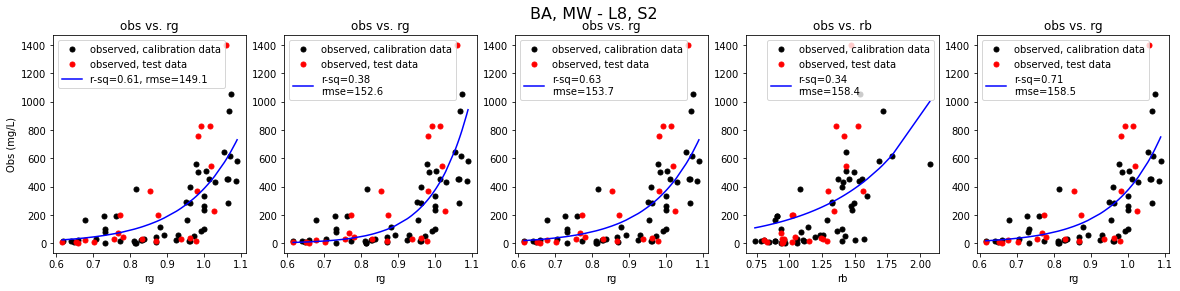

In [0]:
#%% Run model, show results
BAMW_L8S2_2day=test_regression_models([BA_comp, MW_comp],['L8', 'S2'], None, None, 30, 0.70, 'BA, MW - L8, S2') ## check the percentage and number of iterations for all of them 
BAMW_L8S2_2day.head()


In [0]:
# Save or load a result
import pickle
os.chdir('/content/drive/My Drive/Colab Notebooks/regression_files/')

# # save
# top_performance=BAMW_L8S2_2day.loc[1,:]
# pickle.dump(top_performance,open('L8S2.pkl','wb'))

#load
L8S2_reg=pickle.load( open( "L8S2_1.pkl", "rb" ) )
print(L8S2_reg)#.test_date)


band                                                        rg
fit                                                    raw_exp
r2                                                    0.570851
rmse                                                   133.726
x_band       [[0.6164383561643835, 0.6172839506172839, 0.64...
y_fit        [[11.196780671493459, 11.283809601171061, 14.0...
coef         [[0.09170086596349168, 9.156425622791907, -0.8...
test_date    DatetimeIndex(['2015-06-03', '2018-01-25', '20...
Name: 1, dtype: object


In [0]:
# Compute ACC
# Get the dates of the regression test set and find where those are in the "comp_set". 
# Need to do this so that you can get the observations and month for the test dataset
L8S2_reg_dates=L8S2_reg.test_date

L8S2_obs=pd.concat([BA_comp, MW_comp])
L8S2_obs=L8S2_obs[L8S2_obs['obs_mgL']>0]
L8mask=L8S2_obs['LID']==8
S2mask=L8S2_obs['LID']==2
L8S2_obs=L8S2_obs[pd.concat([L8mask, S2mask], axis=1).any(axis=1)]
L8S2_obs.index=L8S2_obs['obs_date']
L8S2_obs_dates=L8S2_obs.index

dates, reg_dates_idx, obs_dates_idx =np.intersect1d(L8S2_reg_dates, L8S2_obs_dates, assume_unique=True, return_indices=True)
L8S2_mx_all=L8S2_obs.loc[dates,:]

month_avg_obs={1:150.81, 2:186.01, 3:182.07, 4:200.84, 5:338.84, 6:330.69,
7:565.89, 8:528.65, 9:1077.08, 10:403.56, 11: 336.90, 12:225.09}
month_avg=np.empty(len(L8S2_mx_all))
i=0
for months in L8S2_mx_all.index.month:
  month_avg[i]=month_avg_obs[months]
  i=i+1

L8S2_mx=pd.DataFrame(data={'obs':L8S2_mx_all.obs_mgL.values,
                               'prediction':0.104*np.exp(8.295*(np.float64(L8S2_mx_all.red.values)/np.float64(L8S2_mx_all.green.values)))-1.11,
                               'month':L8S2_mx_all.index.month,'month_avg':month_avg
                               })

anom=np.mean(L8S2_mx.prediction-L8S2_mx.month_avg)

top=np.mean((L8S2_mx.prediction-L8S2_mx.month_avg)*(L8S2_mx.obs-L8S2_mx.month_avg))
bottom = np.sqrt(np.mean((L8S2_mx.prediction-L8S2_mx.month_avg)**2)*np.mean((L8S2_mx.obs-L8S2_mx.month_avg)**2))
ACC_L8S2=top/bottom

import scipy.stats
print('spearman:',scipy.stats.spearmanr(L8S2_mx.obs,L8S2_mx.prediction)[0])
print('pearson:',scipy.stats.pearsonr(L8S2_mx.obs,L8S2_mx.prediction)[0]**2)
print('ACC:', ACC_L8S2)
print('anom:',anom)

spearman: 0.6126283964709616
pearson: 0.6566570545975255
ACC: 0.8349678424103969
anom: -129.82526425099917


,band,fit,r2,rmse,x_band,y_fit,coef,test_date
0,rn,raw_exp,-0.114912,155.223,"[[0.9747899159663864, 1.0218978102189784, 1.04...","[[344.1967421754862, 326.3367366260422, 318.90...","[[8.101702377772114, -1.1310978121198738, 4.85...","DatetimeIndex(['1991-10-31', '1999-10-21', '20..."
1,rb,raw_exp,-0.136699,156.732,"[[0.9577464788732396, 0.9746835443037974, 0.99...","[[129.6271442490312, 132.1405934024605, 134.47...","[[25.990244380531408, 1.1338592879254668, 0.52...","DatetimeIndex(['1991-10-31', '1999-10-21', '20..."
2,red,raw_exp,-0.00316052,157.397,"[[0.053, 0.057, 0.0675, 0.068, 0.069, 0.069, 0...","[[62.70637267920008, 66.79595420405218, 78.845...","[[2.6978581545809392, 15.794858199974618, 2.30...","DatetimeIndex(['2011-04-28', '2009-10-15', '20..."
3,total,raw_exp,-0.03192,159.637,"[[0.17700000000000002, 0.193, 0.21800000000000...","[[88.2621025068569, 95.69260124885191, 108.574...","[[4.345703696727243, 5.051884890458743, 2.1169...","DatetimeIndex(['2011-04-28', '2009-10-15', '20..."
4,green,raw_exp,-0.0520442,161.187,"[[0.07200000000000001, 0.079, 0.086, 0.088, 0....","[[99.37424045314657, 109.29655248935683, 120.2...","[[3.6074459176656086, 13.595989036087381, 2.33...","DatetimeIndex(['2011-04-28', '2009-10-15', '20..."


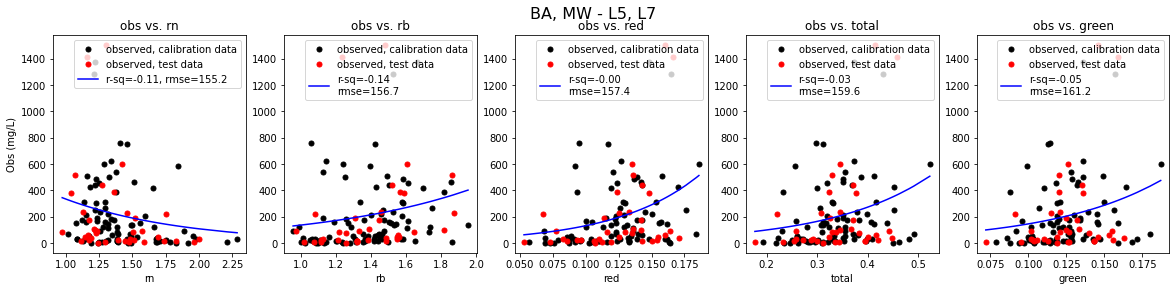

In [0]:
#%%
BAMW_L5L7_2day=test_regression_models([BA_comp, MW_comp],['L5', 'L7','thresh_mask'], 0, 2000, 20, 0.70, 'BA, MW - L5, L7') ## check the percentage and number of iterations for all of them 
BAMW_L5L7_2day.head()

In [0]:
# Save or load a result
import pickle
os.chdir('/content/drive/My Drive/Colab Notebooks/regression_files/')

# # save
# top_performance=BAMW_L5L7_2day.loc[1,:]
# pickle.dump(top_performance,open('L5L7_1.pkl','wb'))

#load
L5L7_reg=pickle.load( open( "L5L7_1.pkl", "rb" ) )
print(L5L7_reg)#.test_date)

band                                                        rg
fit                                                    raw_exp
r2                                                    0.220252
rmse                                                   164.809
x_band       [[0.7215189873417722, 0.736111111111111, 0.739...
y_fit        [[67.75203589681195, 71.71387962344264, 72.562...
coef         [[0.19055066399201878, 3.894552941821752, 3.06...
test_date    DatetimeIndex(['2011-09-29', '1997-10-30', '20...
Name: 1, dtype: object


In [0]:
# Compute ACC
# Get the dates of the regression test set and find where those are in the "comp_set". 
# Need to do this so that you can get the observations and month for the test dataset
L5L7_reg_dates=L5L7_reg.test_date

L5L7_obs=pd.concat([BA_comp, MW_comp])
L5L7_obs=L5L7_obs[L5L7_obs['obs_mgL']>0]
L5mask=L5L7_obs['LID']==5
L7mask=L5L7_obs['LID']==7
L5L7_obs=L5L7_obs[pd.concat([L5mask, L7mask], axis=1).any(axis=1)]
L5L7_obs.index=L5L7_obs['obs_date']
L5L7_obs_dates=L5L7_obs.index

dates, reg_dates_idx, obs_dates_idx =np.intersect1d(L5L7_reg_dates, L5L7_obs_dates, assume_unique=True, return_indices=True)
L5L7_mx_all=L5L7_obs.loc[dates,:]

month_avg_obs={1:150.81, 2:186.01, 3:182.07, 4:200.84, 5:338.84, 6:330.69,
7:565.89, 8:528.65, 9:1077.08, 10:403.56, 11: 336.90, 12:225.09}
month_avg=np.empty(len(L5L7_mx_all))
i=0
for months in L5L7_mx_all.index.month:
  month_avg[i]=month_avg_obs[months]
  i=i+1

L5L7_mx=pd.DataFrame(data={'obs':L5L7_mx_all.obs_mgL.values,
                               'prediction':0.19*np.exp(3.89*(np.float64(L5L7_mx_all.red.values)/np.float64(L5L7_mx_all.green.values)))+3.06,
                               'month':L5L7_mx_all.index.month,'month_avg':month_avg
                               })

top=np.mean((L5L7_mx.prediction-L5L7_mx.month_avg)*(L5L7_mx.obs-L5L7_mx.month_avg))
bottom = np.sqrt(np.mean((L5L7_mx.prediction-L5L7_mx.month_avg)**2)*np.mean((L5L7_mx.obs-L5L7_mx.month_avg)**2))
ACC_L5L7=top/bottom

anom=np.mean(L5L7_mx.prediction-L5L7_mx.month_avg)

import scipy.stats
print('spearman:',scipy.stats.spearmanr(L5L7_mx.obs,L5L7_mx.prediction)[0])
print('pearson:',scipy.stats.pearsonr(L5L7_mx.obs,L5L7_mx.prediction)[0]**2)
print('ACC:',ACC_L5L7)
print('anom:',anom)

spearman: 0.5648059119536601
pearson: 0.21370149311055991
ACC: 0.8858874828982407
anom: -384.9933310483994


,band,fit,r2,rmse,x_band,y_fit,coef,test_date
0,rg,raw_exp,0.402293,201.692,"[[0.6947368421052632, 0.7093023255813954, 0.71...","[[41.06535179132913, 45.0241475501124, 47.1687...","[[0.14791387207570905, 6.31865151407856, 1.236...","DatetimeIndex(['2009-11-26', '2016-10-14', '20..."
1,rn,raw_exp,0.0295805,204.104,"[[0.814516129032258, 0.8782051282051281, 0.935...","[[483.3162222862592, 462.57034001548686, 444.8...","[[9.806860045292328, -0.688855416395022, 4.458...","DatetimeIndex(['2017-03-09', '2018-10-24', '20..."
2,rg,raw_exp,-0.0163123,208.874,"[[0.6947368421052632, 0.7093023255813954, 0.71...","[[41.04657975806107, 45.14865971672132, 47.376...","[[0.15473441546237196, 6.539644286813026, 1.03...","DatetimeIndex(['2017-03-09', '2018-10-24', '20..."
3,nir,raw_exp,-0.0245417,209.718,"[[0.022000000000000002, 0.025, 0.0260000000000...","[[137.01226262226942, 143.0196941617563, 145.0...","[[4.967916803490946, 14.30397072460484, 3.0023...","DatetimeIndex(['2017-03-09', '2018-10-24', '20..."
4,blue,raw_exp,-0.031982,210.478,"[[0.039, 0.039, 0.045, 0.046, 0.046, 0.046, 0....","[[174.05156223061525, 174.05156223061525, 190....","[[4.42540109569179, 14.963464826562774, 3.0884...","DatetimeIndex(['2017-03-09', '2018-10-24', '20..."


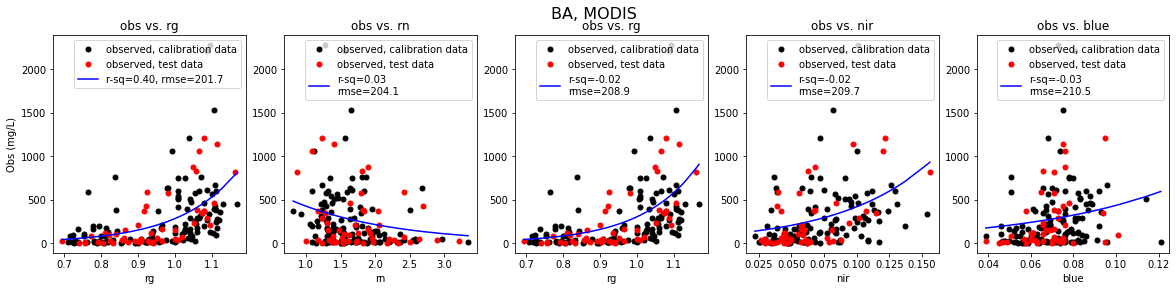

In [0]:
#%%
BAMW_M_2day=test_regression_models([BA_comp, MW_comp],['M', 'thresh_mask'], 0, 3000, 20, 0.70, 'BA, MODIS') ## check the percentage and number of iterations for all of them 
BAMW_M_2day.head()

In [0]:
BAMW_M_2day.loc[0,'coef']

array([array([0.14791387, 6.31865151, 1.23648986])], dtype=object)

In [0]:
# Save or load a result
import pickle
os.chdir('/content/drive/My Drive/Colab Notebooks/regression_files/')

# # save
# top_performance=BAMW_M_2day.loc[0,:]
# pickle.dump(top_performance,open('M_1.pkl','wb'))

#load
M_reg=pickle.load( open( "M_1.pkl", "rb" ) )
print(M_reg)#.test_date)

band                                                        rg
fit                                                    raw_exp
r2                                                    0.402293
rmse                                                   201.692
x_band       [[0.6947368421052632, 0.7093023255813954, 0.71...
y_fit        [[41.06535179132913, 45.0241475501124, 47.1687...
coef         [[0.14791387207570905, 6.31865151407856, 1.236...
test_date    DatetimeIndex(['2009-11-26', '2016-10-14', '20...
Name: 0, dtype: object


In [0]:
# Compute ACC
# Get the dates of the regression test set and find where those are in the "comp_set". 
# Need to do this so that you can get the observations and month for the test dataset
M_reg_dates=M_reg.test_date

M_obs=pd.concat([BA_comp, MW_comp])
M_obs=M_obs[M_obs['obs_mgL']>0]
M_mask=M_obs['LID']==3
M_obs=M_obs[pd.concat([M_mask], axis=1).any(axis=1)]
M_obs.index=pd.to_datetime(M_obs['obs_date'])
M_obs_dates=M_obs.index

M_obs_dates=pd.to_datetime(M_obs_dates)
M_reg_dates=pd.to_datetime(M_reg_dates)
dates, reg_dates_idx, obs_dates_idx =np.intersect1d(M_reg_dates, M_obs_dates, assume_unique=False, return_indices=True)
M_mx_all=M_obs.loc[dates,:]

month_avg_obs={1:150.81, 2:186.01, 3:182.07, 4:200.84, 5:338.84, 6:330.69,
7:565.89, 8:528.65, 9:1077.08, 10:403.56, 11: 336.90, 12:225.09}
month_avg=np.empty(len(M_mx_all))
i=0
for months in M_mx_all.index.month:
  month_avg[i]=month_avg_obs[months]
  i=i+1

M_mx=pd.DataFrame(data={'obs':M_mx_all.obs_mgL.values,
                               'prediction':0.15*np.exp(6.32*(np.float64(M_mx_all.red.values)/np.float64(M_mx_all.green.values)))+1.24,
                               'month':M_mx_all.index.month,'month_avg':month_avg
                               })

top=np.mean((M_mx.prediction-M_mx.month_avg)*(M_mx.obs-M_mx.month_avg))
bottom = np.sqrt(np.mean((M_mx.prediction-M_mx.month_avg)**2)*np.mean((M_mx.obs-M_mx.month_avg)**2))
ACC_M=top/bottom

anom=np.mean(M_mx.prediction-M_mx.month_avg)

import scipy.stats
print('spearman:',scipy.stats.spearmanr(M_mx.obs,M_mx.prediction)[0])
print('pearson:',scipy.stats.pearsonr(M_mx.obs,M_mx.prediction)[0]**2)
print('ACC:',ACC_M)
print('anom:',anom)

spearman: SpearmanrResult(correlation=0.6431581387763857, pvalue=2.064024552779368e-07)
pearson: 0.40997365898836674
ACC: 0.6070156273232855
anom: -277.88670780959313


In [0]:
#All_Landsat_2day=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7', 'L8', 'S2'], 0, 50000, 30, 0.50, 'All - Landsat')
#All_Landsat_2day_wet=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7','wet_mask'], 50, 5000, 30, 0.50, 'All, wet - L5, L7')
#All_Landsat_2day_dry=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7','dry_mask'], 50, 5000, 30, 0.50, 'All, dry - L5, L7')
#
#All_L5L7_2day=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7'], 50, 5000, 30, 0.50, 'All - L5, L7')
#All_L5L7_2day_wet=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7','wet_mask'], 50, 5000, 30, 0.50, 'All, wet - L5, L7')
#All_L5L7_2day_dry=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L5', 'L7','dry_mask'], 50, 5000, 30, 0.50, 'All, dry - L5, L7')

#All_L8_2day=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L8'], 200, 5000, 30, 0.50, 'All - L8')
#All_L8S2_2day=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L8', 'S2'], 200, 5000, 30, 0.50, 'All - L8, S2')
#All_L8S2_2day_wet=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L8', 'S2','wet_mask'], 200, 5000, 30, 0.50, 'All, wet - L8, S2')
#All_L8S2_2day_dry=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['L8', 'S2','dry_mask'], 200, 5000, 30, 0.50, 'All, dry - L8, S2')

#All_M_2day=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['M'], 200, 5000, 30, 0.50, 'All - M')
#All_M_2day_wet=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['M','wet_mask'], 200, 5000, 30, 0.50, 'All, wet - M')
#All_M_2day_dry=test_regression_models([BA_comp, HB_comp, BD_comp, MW_comp],['M','wet_mask'], 200, 5000, 30, 0.50, 'All, dry - M')

#BA_M=test_regression_models([BA_comp, MW_comp],['M', 'wet_mask', 'thresh_mask'], 50, 5000, 30, 0.50, 'BA - M- wet')
#BA_M=test_regression_models([BA_comp, MW_comp, BD_comp, HB_comp],['L5', 'L7', 'dry_mask', 'thresh_mask'],0, 1000, 30, 0.50, 'BA - M- dry')    
# BA_M_2day=test_regression_models([BA_comp],['M'], 50, 5000, 30, 0.50, 'BA - M')
# BA_L5L7_2day_wet=test_regression_models([BA_comp],['L5', 'L7', 'wet_mask'], 50, 5000, 30, 0.50, 'BA, wet- L5, L7')
# BA_L5L7_2day_dry=test_regression_models([BA_comp],['L5', 'L7', 'dry_mask', 'thresh_mask'], 0, 500, 30, 0.50, 'BA, dry - L5, L7')
# BA_L5L7_2day=test_regression_models([BA_comp],['L5', 'L7'], 50, 5000, 30, 0.50, 'BA - L5, L7')

# BA_L8S2_2day_wet=test_regression_models([BA_comp],['L8', 'S2', 'wet_mask'], 0, 5000, 30, 0.50, 'BA - L8, S2, wet')
# BA_L8S2_2day_dry=test_regression_models([BA_comp],['L8', 'S2', 'dry_mask'], 0, 300, 30, 0.50, 'BA - L8, S2, dry')

# BA_L8_2day=test_regression_models([BA_comp],['L8'], 200, 5000, 30, 0.50, 'BA - L8')
# BA_Landsat_2day=test_regression_models([BA_comp],['L5', 'L7', 'L8', 'S2'], 0, 50000, 30, 0.50, 'BA - Landsat')
# BA_Landsat_2day_wet=test_regression_models([BA_comp],['L5', 'L7', 'L8', 'S2','wet_mask'], 0, 50000, 30, 0.50, 'BA - Landsat')
# BA_Landsat_2day_dry=test_regression_models([BA_comp],['L5', 'L7', 'L8', 'S2','dry_mask'], 0, 50000, 30, 0.50, 'BA - Landsat')

# MW_M_2day=test_regression_models([MW_comp],['M'], 50, 5000, 30, 0.50, 'MW - M')
# MW_L5L7_2day=test_regression_models([MW_comp],['L5', 'L7'], 50, 5000, 30, 0.50, 'MW - L5, L7')
# MW_L8S2_2day=test_regression_models([MW_comp],['L8', 'S2'], 50, 5000, 30, 0.50, 'MW - L8, S2')
# MW_Landsat_2day=test_regression_models([MW_comp],['L5', 'L7', 'L8', 'S2'], 200, 5000, 30, 0.50, 'MW - Landsat')
# #%%
# HB_M_2day=test_regression_models([HB_comp],['M'], 50, 5000, 30, 0.50, 'HB - M')
# HB_L5L7_2day=test_regression_models([HB_comp],['L5', 'L7'], 50, 5000, 30, 0.50, 'HB - L5, L7')
# HB_L8S2_2day=test_regression_models([HB_comp],['L8', 'S2'], 50, 5000, 30, 0.50, 'HB - L8, S2')
# HB_Landsat_2day=test_regression_models([HB_comp],['L5', 'L7','L8', 'S2'], 50, 5000, 30, 0.50, 'HB - Landsat')
# #%%
# BD_L5L7_2day=test_regression_models([BD_comp],['L5', 'L7'], 50, 5000, 30, 0.50, 'BD - L5, L7')
# BD_L5L7_2day_wet=test_regression_models([BD_comp],['L5', 'L7', 'wet_mask'], 50, 5000, 30, 0.50, 'BD - L5, L7, wet')
# BD_L5L7_2day_dry=test_regression_models([BD_comp],['L5', 'L7', 'dry_mask'], 50, 5000, 30, 0.50, 'BD- L5, L7, dry ')
# #%%
# BD_L8S2_2day=test_regression_models([BD_comp],['L8', 'S2'], 50, 5000, 30, 0.50, 'BD - L8, S2')
# BD_L8S2_2day_wet=test_regression_models([BD_comp],['L8', 'S2', 'wet_mask'], 50, 5000, 30, 0.50, 'BD - L8, S2, wet')
# BD_L8S2_2day_dry=test_regression_models([BD_comp],['L8', 'S2', 'dry_mask'], 50, 5000, 30, 0.50, 'BD - L8, S2, dry')

# BD_Landsat_2day=test_regression_models([BD_comp],['L5', 'L7','L8', 'S2'], 50, 5000, 30, 0.50, 'BD - L8, S2')
# BD_Landsat_2day=test_regression_models([BD_comp],['L5', 'L7','L8', 'S2'], 50, 5000, 30, 0.50, 'BD - L8, S2')
# BD_Landsat_2day=test_regression_models([BD_comp],['L5', 'L7','L8', 'S2'], 50, 5000, 30, 0.50, 'BD - L8, S2')


,band,fit,r2,rmse,x_band,y_fit,coef
0,rg,raw_exp,0.704278,127.05,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[19.10465309217952, 19.23086168762959, 23.186...","[[0.12142813495932127, 7.78676509646245, 0.258..."
1,rg,raw_2ord,0.663374,135.552,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[80.6831114685233, 79.71004773283312, 55.1787...","[[5206.893558268055, -7574.605905700528, 2771...."
2,rb,raw_linear,0.610809,145.751,"[[0.7375, 0.78125, 0.8076923076923077, 0.80952...","[[-74.81618390815453, -45.96293739726366, -28....","[[659.5027773917902, -561.1994822345998]]"
3,rb,raw_2ord,0.589157,149.751,"[[0.7375, 0.78125, 0.8076923076923077, 0.80952...","[[-96.76944541176135, -63.09265294432987, -42....","[[-108.63357008385451, 934.7424909632886, -727..."
4,rb,raw_exp,0.556464,155.595,"[[0.7375, 0.78125, 0.8076923076923077, 0.80952...","[[111.2565980554845, 119.2562522844597, 124.36...","[[2.4965686645622576, 1.5870932754473608, 2.62..."
5,rg,raw_linear,0.40057,180.884,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[-129.97401938762061, -128.77952646371364, -9...","[[1412.607331812289, -1000.7593609157439]]"
6,rg,raw_exp,0.534701,241.15,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[19.430360396579314, 19.55438217974802, 23.42...","[[0.16482872582882283, 7.524413187106252, 0.13..."
7,rg,raw_2ord,0.51708,245.673,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[121.36227965155103, 120.26452755506989, 92.1...","[[5059.284343039052, -7539.95357965731, 2846.7..."
8,rg,raw_linear,0.401247,273.555,"[[0.6164383561643835, 0.6172839506172839, 0.64...","[[-121.21713042445072, -120.1333108212607, -89...","[[1281.7250627324447, -911.3216211499303]]"
9,rb,raw_2ord,0.327599,289.891,"[[0.7375, 0.78125, 0.8076923076923077, 0.80952...","[[-83.96251235197877, -56.27927702420914, -39....","[[16.904071469397877, 607.086606090588, -540.8..."
